In [1]:
# !pip3 install numpy alpaca-trade-api dotenv gymnasium tensorflow schedule
!pip3 install -r requirements.txt

  Using cached alpaca_trade_api-3.0.0-py3-none-any.whl (33 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 46.5 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 77.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 13.5 MB/s eta 0:00:0000:0100:01
  Using cached glob2-0.7.tar.gz (10 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.5/552.5 KB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 76.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 65.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.5/671.5 KB 49.9 MB/s eta 0:00:00
  

In [2]:
import os
import pandas as pd
import numpy as np
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import time
import schedule
from datetime import datetime, timedelta
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import gymnasium as gym
from gymnasium import spaces
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# 加载环境变量
load_dotenv()

# Alpaca API凭证
API_KEY = os.getenv('ALPACA_API_KEY')
API_SECRET = os.getenv('ALPACA_API_SECRET')
BASE_URL = 'https://paper-api.alpaca.markets'

# 初始化Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# 模型和数据保存路径
MODEL_DIR = 'models'
DATA_DIR = 'data'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

########## 指标计算函数 ##########

# def calculate_rsi(data, window=14):
#     """计算RSI指标"""
#     delta = data['close'].diff()
#     gain = delta.where(delta > 0, 0)
#     loss = -delta.where(delta < 0, 0)
#     avg_gain = gain.rolling(window).mean()
#     avg_loss = loss.rolling(window).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi

def calculate_macd(data, fast=12, slow=26, signal=9):
    """计算MACD指标"""
    # 计算快线与慢线
    ema_fast = data['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = data['close'].ewm(span=slow, adjust=False).mean()
    
    # MACD线 = 快线 - 慢线
    macd_line = ema_fast - ema_slow
    
    # 信号线 = MACD的EMA
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    
    # MACD柱状图 = MACD线 - 信号线
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

def calculate_bollinger_bands(data, window=20, num_std=2):
    """计算布林带指标"""
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return rolling_mean, upper_band, lower_band

def calculate_atr(data, window=14):
    """计算平均真实范围(ATR)指标"""
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    
    atr = true_range.rolling(window=window).mean()
    return atr

def get_market_regime(spy_data, window=50):
    """判断当前市场状态（牛市/熊市/震荡市）"""
    # 获取SPY ETF数据计算大盘趋势
    if spy_data is None or len(spy_data) < window:
        return "unknown"
    
    # 计算短期和长期趋势
    spy_data['short_ma'] = spy_data['close'].rolling(window=20).mean()
    spy_data['long_ma'] = spy_data['close'].rolling(window=50).mean()
    
    # 计算波动率
    spy_data['volatility'] = spy_data['close'].pct_change().rolling(window=20).std() * np.sqrt(252)
    
    # 获取最新数据
    latest = spy_data.iloc[-1]
    
    # 判断市场状态
    if latest['short_ma'] > latest['long_ma'] * 1.05:
        regime = "bull"  # 牛市
    elif latest['short_ma'] < latest['long_ma'] * 0.95:
        regime = "bear"  # 熊市
    else:
        if latest['volatility'] > 0.15:  # 高波动
            regime = "volatile"  # 震荡市
        else:
            regime = "neutral"  # 中性市场
    
    return regime

def get_vix_level(vix_data):
    """获取VIX恐慌指数水平"""
    if vix_data is None or len(vix_data) < 5:
        return "medium"
    
    latest_vix = vix_data['close'].iloc[-1]
    
    if latest_vix > 30:
        return "high"  # 高恐慌
    elif latest_vix < 15:
        return "low"  # 低恐慌
    else:
        return "medium"  # 中等恐慌

########## 数据获取与处理 ##########

########## 机器学习部分 ##########

def prepare_features(data):
    """准备机器学习特征"""
    # 删除包含NaN的行
    data = data.dropna()
    
    # 选择特征
    features = [
        'rsi', 'macd', 'signal', 'hist', 
        'ma20', 'atr', 'trend_5d', 'trend_10d', 'trend_20d',
        'ma10_ratio', 'ma50_ratio', 'volatility'
    ]
    
    X = data[features]
    y = data['target']
    
    return X, y

########## 强化学习部分 ##########

class TradingEnvironment(gym.Env):
    """交易环境，用于强化学习"""
    
    def __init__(self, data, initial_balance=10000):
        super(TradingEnvironment, self).__init__()
        
        self.data = data
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.position = 0
        self.current_step = 0
        self.total_steps = len(data) - 1
        
        # 状态空间：[持仓量, 账户余额, RSI, MACD, hist, 波动率, 趋势5日, 趋势20日, MA10比率, MA50比率]
        self.observation_space = spaces.Box(
            low=np.array([-10, 0, 0, -100, -100, 0, -1, -1, 0, 0]),
            high=np.array([10, 100000, 100, 100, 100, 1, 1, 1, 2, 2]),
            dtype=np.float32
        )
        
        # 动作空间：0=卖出, 1=持有, 2=买入
        self.action_space = spaces.Discrete(3)
        
    def reset(self, **kwargs):
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        
        return self._get_observation(), {}
    
    def _get_observation(self):
        """获取当前状态"""
        current_data = self.data.iloc[self.current_step]
        
        # 创建状态向量
        obs = np.array([
            self.position,  # 当前持仓
            self.balance,   # 账户余额
            current_data['rsi'],
            current_data['macd'],
            current_data['hist'],
            current_data['volatility'],
            current_data['trend_5d'],
            current_data['trend_20d'],
            current_data['ma10_ratio'],
            current_data['ma50_ratio']
        ], dtype=np.float32)
        
        return obs
    
    def _calculate_reward(self, action):
        """计算奖励"""
        current_price = self.data.iloc[self.current_step]['close']
        next_price = self.data.iloc[self.current_step + 1]['close'] if self.current_step + 1 < len(self.data) else current_price
        
        price_change = (next_price - current_price) / current_price
        
        if action == 0:  # 卖出
            if self.position > 0:  # 如果有持仓，卖出是对的
                reward = -price_change * 10  # 价格下跌时奖励高
            else:  # 如果没有持仓，不应该卖
                reward = -0.1
        elif action == 1:  # 持有
            if self.position > 0:  # 如果有持仓
                reward = price_change * 5  # 根据价格变动奖励
            else:
                reward = 0  # 没有持仓时持有，中性奖励
        elif action == 2:  # 买入
            if self.position == 0:  # 如果没有持仓，买入是对的
                reward = price_change * 10  # 价格上涨时奖励高
            else:  # 如果已经有持仓，不应该买
                reward = -0.1
        
        return reward
    
    def step(self, action):
        """执行动作，更新环境"""
        # 获取当前价格
        current_price = self.data.iloc[self.current_step]['close']
        
        # 执行交易
        if action == 0:  # 卖出
            if self.position > 0:
                self.balance += current_price * self.position
                self.position = 0
        elif action == 2:  # 买入
            if self.position == 0 and self.balance >= current_price:
                # 计算可买入的股数（简化，实际上应该考虑手续费等）
                shares_to_buy = self.balance // current_price
                if shares_to_buy > 0:
                    self.position = shares_to_buy
                    self.balance -= shares_to_buy * current_price
        
        # 计算奖励
        reward = self._calculate_reward(action)
        
        # 移动到下一步
        self.current_step += 1
        done = self.current_step >= self.total_steps
        
        # 如果结束，计算最终回报
        if done:
            final_portfolio_value = self.balance + self.position * self.data.iloc[-1]['close']
            portfolio_return = (final_portfolio_value - self.initial_balance) / self.initial_balance
            # 额外奖励/惩罚基于总回报
            reward += portfolio_return * 100
        
        info = {}
        return self._get_observation(), reward, done, False, info
    
    def render(self, mode='human'):
        """渲染环境状态"""
        if self.current_step > 0:
            current_price = self.data.iloc[self.current_step - 1]['close']
            portfolio_value = self.balance + self.position * current_price
            print(f"Step: {self.current_step}, Price: ${current_price:.2f}, "
                  f"Balance: ${self.balance:.2f}, Position: {self.position}, "
                  f"Portfolio Value: ${portfolio_value:.2f}")

def build_dqn_model(state_size, action_size):
    """构建深度Q网络模型"""
    model = Sequential()
    model.add(Dense(64, input_dim=state_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def rl_decision(symbol, data, rl_model):
    """使用强化学习模型做出决策"""
    if rl_model is None or data is None or len(data) < 20:
        return 1  # 默认持有
    
    # 创建临时环境用于决策
    env = TradingEnvironment(data)
    
    # 获取当前状态
    state, _ = env.reset()
    env.current_step = len(data) - 1  # 设置为最新数据点
    state = env._get_observation()
    
    # 预测动作
    act_values = rl_model.predict(state.reshape(1, -1), verbose=0)
    action = np.argmax(act_values[0])
    
    # 返回决策: 0=卖出, 1=持有, 2=买入
    return action

########## 交易决策与执行 ##########



==== 所有盈亏记录 ====
交易日数: 5
盈利天数: 0 (0.00%)
亏损天数: 5 (100.00%)
总盈亏: $-27.40
平均日盈亏: $-5.48
最大单日盈利: $-0.60
最大单日亏损: $-6.70
累计收益率: -0.03%
年化收益率: 0.00%
年化波动率: 4.33%
夏普比率: -0.46
最大回撤: -0.03%
市场相关性: nan
相对市场平均超额收益: -0.01%


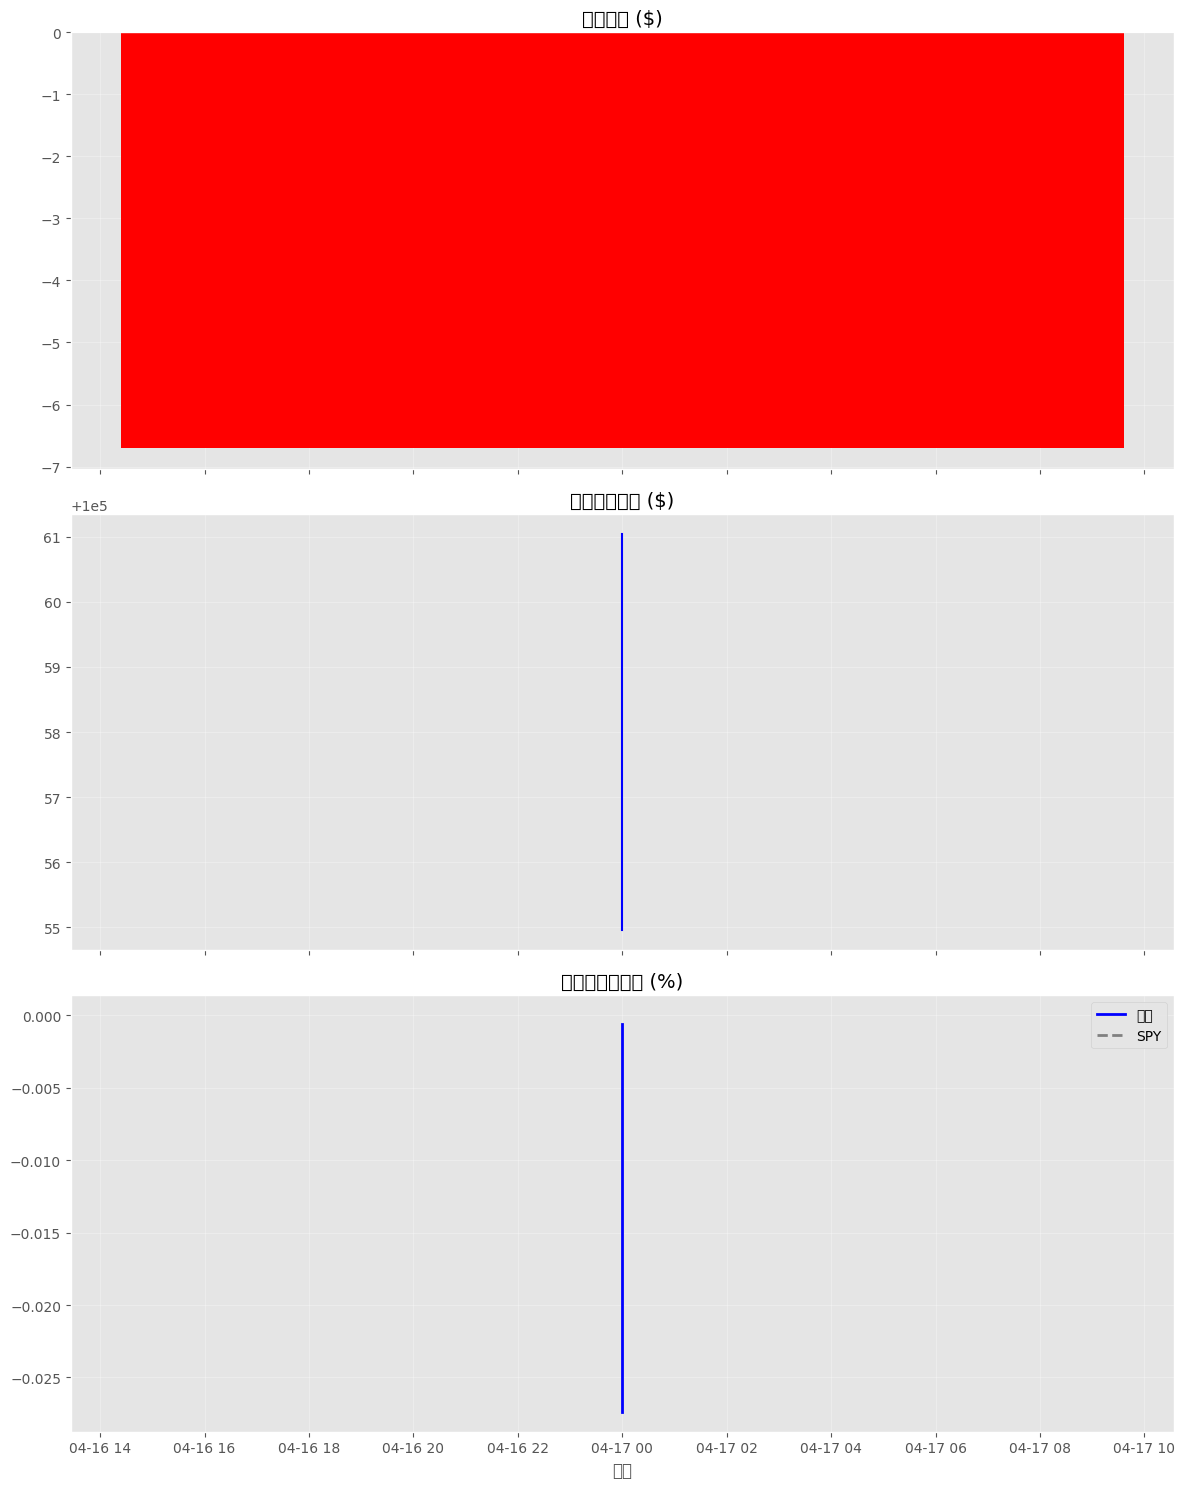

In [45]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import time
import schedule
from datetime import datetime, timedelta
import joblib
import glob  # 用于查找模型文件



# 加载环境变量
load_dotenv()

# Alpaca API凭证
API_KEY = os.getenv('ALPACA_API_KEY')
API_SECRET = os.getenv('ALPACA_API_SECRET')
BASE_URL = 'https://paper-api.alpaca.markets'

# 初始化Alpaca API
api = tradeapi.REST(API_KEY, API_SECRET, BASE_URL, api_version='v2')

# 模型和数据保存路径
MODEL_DIR = 'models'
DATA_DIR = 'data'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

def calculate_rsi(data, window=14):
    """计算RSI指标"""
    delta = data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def get_stock_data(symbol, days=120):
    """获取股票数据并计算各种技术指标"""
    # 获取历史数据
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)
    start = start_date.strftime('%Y-%m-%d')
    end = end_date.strftime('%Y-%m-%d')
    
    try:
        # 获取股票数据
        bars = api.get_bars(symbol, '1D', start=start, end=end, adjustment='raw', feed='iex').df
        
        if len(bars) > 0:
            # 计算技术指标
            bars['rsi'] = calculate_rsi(bars)
            # 这里可以添加其他指标计算
            
            # 添加简单的趋势特征
            bars['trend_5d'] = bars['close'].pct_change(5)
            bars['ma10'] = bars['close'].rolling(10).mean()
            bars['ma50'] = bars['close'].rolling(50).mean()
            
            return bars
        else:
            print(f"未找到{symbol}的数据")
            return None
    except Exception as e:
        print(f"获取{symbol}数据失败: {str(e)}")
        return None

def get_context_data():
    """获取市场上下文数据（大盘状态、VIX等）"""
    try:
        # 获取SPY ETF数据作为大盘指标
        spy_data = get_stock_data('SPY', days=60)
        
        # 判断市场状态
        market_regime = "neutral"  # 默认中性
        if spy_data is not None and len(spy_data) > 20:
            # 简单判断：短期均线与长期均线的关系
            spy_data['ma20'] = spy_data['close'].rolling(20).mean()
            spy_data['ma50'] = spy_data['close'].rolling(50).mean()
            latest = spy_data.iloc[-1]
            
            if latest['ma20'] > latest['ma50'] * 1.03:
                market_regime = "bull"  # 牛市
            elif latest['ma20'] < latest['ma50'] * 0.97:
                market_regime = "bear"  # 熊市
        
        # 简化版的VIX评估
        vix_level = "medium"  # 默认中等
        
        return {
            'market_regime': market_regime,
            'vix_level': vix_level,
            'spy_data': spy_data
        }
    except Exception as e:
        print(f"获取上下文数据失败: {str(e)}")
        return {
            'market_regime': 'neutral',
            'vix_level': 'medium',
            'spy_data': None
        }

def get_dynamic_thresholds(context):
    """根据市场上下文动态调整RSI阈值"""
    # 默认阈值
    rsi_buy = 30
    rsi_sell = 70
    
    # 根据市场状态调整
    if context['market_regime'] == 'bull':
        # 牛市：提高买入阈值，降低卖出阈值，因为牛市中股票倾向于上涨
        rsi_buy = 40
        rsi_sell = 80
    elif context['market_regime'] == 'bear':
        # 熊市：降低买入阈值，降低卖出阈值，因为熊市中股票倾向于下跌
        rsi_buy = 20
        rsi_sell = 60
    
    # 根据VIX调整
    if context['vix_level'] == 'high':
        # 高恐慌时降低买入阈值
        rsi_buy = max(15, rsi_buy - 10)
    elif context['vix_level'] == 'low':
        # 低恐慌时提高卖出阈值
        rsi_sell = min(85, rsi_sell + 5)
    
    return rsi_buy, rsi_sell

# 股票风险评估
def assess_stock_risk(symbol, days=120):
    """评估股票风险，返回风险类别和风险指标"""
    try:
        # 获取股票数据
        data = get_stock_data(symbol, days=days)
        
        if data is None or len(data) < 20:
            return "unknown", None
        
        # 计算风险指标
        # 1. 波动率 (标准差 * sqrt(交易日))
        volatility = data['close'].pct_change().std() * np.sqrt(252)
        
        # 2. 获取SPY数据作为市场基准
        market_data = get_stock_data('SPY', days=days)
        
        # 3. 计算贝塔系数
        if market_data is not None and len(market_data) >= 20:
            stock_returns = data['close'].pct_change().dropna()
            market_returns = market_data['close'].pct_change().dropna()
            
            # 确保两个序列长度相同
            min_length = min(len(stock_returns), len(market_returns))
            stock_returns = stock_returns.iloc[-min_length:]
            market_returns = market_returns.iloc[-min_length:]
            
            # 计算协方差和市场方差
            covariance = stock_returns.cov(market_returns)
            market_variance = market_returns.var()
            
            # 计算贝塔系数
            beta = covariance / market_variance if market_variance != 0 else 1.0
        else:
            beta = 1.0
        
        # 4. 最大回撤
        roll_max = data['close'].cummax()
        drawdown = (data['close'] - roll_max) / roll_max
        max_drawdown = drawdown.min()
        
        # 风险指标集合
        risk_metrics = {
            'volatility': volatility,
            'beta': beta,
            'max_drawdown': max_drawdown
        }
        
        # 风险分类
        if volatility > 0.3 or beta > 1.5 or max_drawdown < -0.3:
            risk_category = "high"
        elif volatility > 0.15 or beta > 1.0 or max_drawdown < -0.2:
            risk_category = "medium"
        else:
            risk_category = "low"
            
        return risk_category, risk_metrics
        
    except Exception as e:
        print(f"评估{symbol}风险时出错: {str(e)}")
        return "unknown", None


# 根据股票风险获取潜在投资股票
def get_potential_stocks(min_price=5, max_price=500, limit=50):
    """获取潜在投资股票列表"""
    try:
        # 获取活跃股票列表
        active_assets = api.list_assets(status='active', asset_class='us_equity')
        
        # 过滤标准
        tradable_assets = [asset for asset in active_assets 
                          if asset.tradable and 
                          asset.fractionable and  # 支持零股交易
                          not asset.symbol.startswith(('GOOG', '$')) and  # 排除特定前缀
                          '.' not in asset.symbol]  # 排除特殊符号
        
        # 对潜在股票获取当前市场数据
        potential_stocks = []
        
        # 限制处理的数量以避免API限制
        for asset in tradable_assets[:200]:  # 处理前200个活跃资产
            try:
                # 获取最新报价
                last_quote = api.get_latest_quote(asset.symbol)
                last_price = last_quote.ap if hasattr(last_quote, 'ap') else None
                
                # 价格筛选
                if last_price and min_price <= last_price <= max_price:
                    potential_stocks.append({
                        'symbol': asset.symbol,
                        'name': asset.name,
                        'price': last_price
                    })
                    
                # 一旦收集到足够多的股票就停止
                if len(potential_stocks) >= limit:
                    break
            except Exception as e:
                # 忽略单个股票的错误，继续处理其他股票
                pass
        
        return potential_stocks
        
    except Exception as e:
        print(f"获取潜在股票时出错: {str(e)}")
        return []


# 根据选出的股票来构建投资组合
def build_portfolio(capital=1000, risk_allocation={'low': 0.5, 'medium': 0.3, 'high': 0.2}, max_stocks=15):
    """根据风险偏好构建投资组合"""
    print("\n开始构建投资组合...")
    
    # 获取潜在股票
    potential_stocks = get_potential_stocks(limit=100)
    print(f"找到 {len(potential_stocks)} 只潜在股票")
    
    if not potential_stocks:
        print("未找到符合条件的股票")
        return {}
    
    # 评估每只股票的风险
    categorized_stocks = {'low': [], 'medium': [], 'high': [], 'unknown': []}
    
    for stock in potential_stocks:
        symbol = stock['symbol']
        risk_category, risk_metrics = assess_stock_risk(symbol)
        
        if risk_metrics:
            stock['risk_category'] = risk_category
            stock['risk_metrics'] = risk_metrics
            categorized_stocks[risk_category].append(stock)
    
    # 打印每个风险类别的股票数量
    for category, stocks in categorized_stocks.items():
        if category != 'unknown':
            print(f"{category.capitalize()}风险股票: {len(stocks)}只")
    
    # 确定每个风险类别的资金分配
    allocation = {}
    for category, ratio in risk_allocation.items():
        stocks_in_category = categorized_stocks[category]
        if not stocks_in_category:
            continue
            
        # 该类别的总资金
        category_capital = capital * ratio
        
        # 确定该类别要选择的股票数量
        num_stocks = min(len(stocks_in_category), max(1, int(max_stocks * ratio)))
        
        # 根据一些标准选择股票（这里简化为随机选择）
        # 实际中可以用更复杂的标准，如市值、财务状况等
        selected_stocks = stocks_in_category[:num_stocks]
        
        # 计算每只股票的投资金额
        stock_capital = category_capital / len(selected_stocks)
        
        for stock in selected_stocks:
            symbol = stock['symbol']
            price = stock['price']
            
            # 计算可购买的股数（向下取整）
            shares = max(1, int(stock_capital / price))
            
            allocation[symbol] = {
                'risk_category': category,
                'capital': stock_capital,
                'price': price,
                'shares': shares,
                'risk_metrics': stock['risk_metrics']
            }
    
    print(f"投资组合已构建完成，包含 {len(allocation)} 只股票")
    return allocation


# 对投资组合进行监控
def execute_portfolio(portfolio, dry_run=True):
    """执行投资组合交易（购买分配的股票）"""
    print("\n开始执行投资组合交易..." + (" (模拟模式)" if dry_run else ""))
    
    # 投资组合摘要
    total_investment = sum(info['capital'] for info in portfolio.values())
    print(f"总投资金额: ${total_investment:.2f}")
    
    # 按风险类别分组
    by_risk = {'low': [], 'medium': [], 'high': []}
    for symbol, info in portfolio.items():
        by_risk[info['risk_category']].append(symbol)
    
    for risk, symbols in by_risk.items():
        if symbols:
            print(f"{risk.capitalize()}风险组合: {', '.join(symbols)}")
    
    if dry_run:
        print("模拟模式，不执行实际交易")
        return True
    
    # 执行实际交易
    executed_orders = []
    failed_orders = []
    
    for symbol, info in portfolio.items():
        shares = info['shares']
        
        if shares <= 0:
            continue
            
        try:
            # 检查是否已有持仓
            try:
                position = api.get_position(symbol)
                print(f"已持有 {position.qty} 股 {symbol}，跳过")
                continue
            except:
                # 没有持仓，继续购买
                pass
                
            # 提交市场买单
            order = api.submit_order(
                symbol=symbol,
                qty=shares,
                side='buy',
                type='market',
                time_in_force='day'
            )
            
            print(f"已提交买入订单: {shares} 股 {symbol}, 订单ID: {order.id}")
            executed_orders.append(order)
            
            # 为新买入的股票设置止损
            time.sleep(2)  # 等待订单处理
            order_status = api.get_order(order.id)
            
            if order_status.status == 'filled':
                set_stop_loss(symbol, stop_percent=0.05)
                
        except Exception as e:
            print(f"买入 {symbol} 失败: {str(e)}")
            failed_orders.append(symbol)
    
    print(f"成功执行 {len(executed_orders)} 个订单，失败 {len(failed_orders)} 个")
    return len(failed_orders) == 0


# 对投资组合进行再平衡
def rebalance_portfolio(risk_allocation={'low': 0.5, 'medium': 0.3, 'high': 0.2}, threshold=0.1):
    """检查并再平衡投资组合"""
    print("\n开始检查投资组合平衡...")
    
    try:
        # 获取当前持仓
        positions = api.list_positions()
        
        if not positions:
            print("当前无持仓，无需再平衡")
            return False
        
        # 计算当前投资组合总价值
        total_value = sum(float(position.market_value) for position in positions)
        
        # 按风险类别分类当前持仓
        current_allocation = {'low': 0, 'medium': 0, 'high': 0}
        position_by_risk = {'low': [], 'medium': [], 'high': []}
        
        for position in positions:
            symbol = position.symbol
            market_value = float(position.market_value)
            
            # 获取风险类别
            risk_category, _ = assess_stock_risk(symbol)
            
            if risk_category in current_allocation:
                current_allocation[risk_category] += market_value
                position_by_risk[risk_category].append({
                    'symbol': symbol,
                    'shares': int(position.qty),
                    'value': market_value
                })
        
        # 计算当前配置比例
        current_ratio = {
            category: value / total_value if total_value > 0 else 0
            for category, value in current_allocation.items()
        }
        
        # 打印当前配置
        print("当前投资组合配置:")
        for category, ratio in current_ratio.items():
            print(f"{category.capitalize()}风险: ${current_allocation[category]:.2f} ({ratio:.2%})")
        
        # 检查是否需要再平衡
        needs_rebalance = False
        for category, target_ratio in risk_allocation.items():
            current = current_ratio.get(category, 0)
            if abs(current - target_ratio) > threshold:
                needs_rebalance = True
                print(f"{category.capitalize()}风险资产偏离目标: 当前 {current:.2%} vs 目标 {target_ratio:.2%}")
        
        if not needs_rebalance:
            print("投资组合平衡，无需调整")
            return False
        
        print("需要再平衡投资组合，建议调整:")
        
        # 计算每个类别需要调整的金额
        adjustments = {}
        for category, target_ratio in risk_allocation.items():
            current_value = current_allocation.get(category, 0)
            target_value = total_value * target_ratio
            adjustment = target_value - current_value
            adjustments[category] = adjustment
            
            if adjustment > 0:
                print(f"增加 {category} 风险资产: ${adjustment:.2f}")
            else:
                print(f"减少 {category} 风险资产: ${-adjustment:.2f}")
        
        # 这里简单返回需要调整，具体实施再平衡可以根据需要添加
        return adjustments
        
    except Exception as e:
        print(f"检查投资组合平衡时出错: {str(e)}")
        return False


# 训练模型
def train_ml_model(symbol, force_retrain=False):
    """训练或加载机器学习模型"""
    model_path = f"{MODEL_DIR}/{symbol}_ml_model.joblib"
    scaler_path = f"{MODEL_DIR}/{symbol}_scaler.joblib"
    
    # 检查模型是否存在且是否需要强制重新训练
    if os.path.exists(model_path) and not force_retrain:
        try:
            model = joblib.load(model_path)
            scaler = joblib.load(scaler_path)
            print(f"已加载{symbol}的现有模型")
            return model, scaler
        except:
            print(f"加载{symbol}的模型失败，将重新训练")
    
    # 获取历史数据
    data = get_stock_data(symbol, days=365)  # 使用一年的数据
    
    if data is None or len(data) < 50:
        print(f"没有足够的数据来训练{symbol}的模型")
        return None, None
    
    # 准备特征和目标
    data = data.dropna()
    
    # 创建目标变量 - 第二天的涨跌
    data['next_return'] = data['close'].pct_change().shift(-1)
    data['target'] = np.where(data['next_return'] > 0, 1, 0)
    
    # 选择特征
    features = ['rsi', 'trend_5d', 'ma10', 'ma50']
    X = data[features].dropna()
    y = data.loc[X.index, 'target']
    
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 训练随机森林模型
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_scaled, y)
    
    # 保存模型和缩放器
    os.makedirs(MODEL_DIR, exist_ok=True)
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    
    print(f"{symbol}的机器学习模型训练完成")
    return model, scaler

def train_rl_agent(symbol, force_retrain=False):
    """训练或加载一个简单的DQN强化学习模型"""
    model_path = f"{MODEL_DIR}/{symbol}_rl_model.h5"
    
    # 检查模型是否存在且是否需要强制重新训练
    if os.path.exists(model_path) and not force_retrain:
        try:
            from tensorflow.keras.models import load_model
            model = load_model(model_path)
            print(f"已加载{symbol}的强化学习模型")
            return model
        except:
            print(f"加载{symbol}的强化学习模型失败，将训练简化版本")
    
    # 简化的RL模型（DQN）
    try:
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense
        from tensorflow.keras.optimizers import Adam
        
        # 创建一个简单的神经网络模型
        # 输入: [RSI, MA10/Price, MA50/Price, 波动率, 趋势]
        # 输出: [卖出, 持有, 买入] 的Q值
        model = Sequential()
        model.add(Dense(24, input_dim=5, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(3, activation='linear'))  # Q值估计 - 卖出/持有/买入
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        
        # 保存模型
        os.makedirs(MODEL_DIR, exist_ok=True)
        model_path_keras = model_path.replace('.h5', '.keras')
        model.save(model_path_keras)
        
        print(f"{symbol}的简化强化学习模型已创建")
        return model
    except Exception as e:
        print(f"创建强化学习模型失败: {str(e)}")
        return None

def hybrid_trading_decision(symbol, context, data=None, ml_model=None, ml_scaler=None, rl_model=None):
    """综合使用规则、机器学习和强化学习的交易决策"""
    if data is None:
        data = get_stock_data(symbol)
    
    if data is None or len(data) < 20:
        return "无足够数据"
    
    # 获取动态阈值
    rsi_buy, rsi_sell = get_dynamic_thresholds(context)
    
    # 获取最新RSI和其他指标
    latest = data.iloc[-1]
    current_rsi = latest['rsi']
    
    print(f"{symbol} 最新RSI: {current_rsi:.2f}")
    print(f"动态RSI阈值 - 买入: {rsi_buy}, 卖出: {rsi_sell}")
    
    # 检查是否已持有该股票
    try:
        position = api.get_position(symbol)
        has_position = True
        position_qty = int(position.qty)
        print(f"当前持有 {position_qty} 股 {symbol}")
    except:
        has_position = False
        position_qty = 0
        print(f"当前未持有 {symbol}")
    
    # 规则信号
    rule_signal = None
    if current_rsi <= rsi_buy:
        rule_signal = "买入"
    elif current_rsi >= rsi_sell:
        rule_signal = "卖出"
    else:
        rule_signal = "持有"
    
    # 机器学习信号
    ml_signal = None
    if ml_model is not None and ml_scaler is not None:
        try:
            prob_up = ml_prediction(data, ml_model, ml_scaler)
            print(f"机器学习预测上涨概率: {prob_up:.2f}")
            
            if prob_up > 0.65:
                ml_signal = "买入"
            elif prob_up < 0.35:
                ml_signal = "卖出"
            else:
                ml_signal = "持有"
        except Exception as e:
            print(f"机器学习预测失败: {str(e)}")
            ml_signal = "持有"  # 默认持有
    
    # 强化学习信号
    rl_signal = None
    if rl_model is not None:
        try:
            rl_action = rl_prediction(data, rl_model)
            if rl_action == 2:  # 买入
                rl_signal = "买入"
            elif rl_action == 0:  # 卖出
                rl_signal = "卖出"
            else:  # 持有
                rl_signal = "持有"
            print(f"强化学习建议: {rl_signal}")
        except Exception as e:
            print(f"强化学习预测失败: {str(e)}")
            rl_signal = "持有"  # 默认持有
    
    # 综合决策
    signals = [rule_signal]
    if ml_signal:
        signals.append(ml_signal)
    if rl_signal:
        signals.append(rl_signal)
    
    # 简单多数投票
    buy_count = signals.count("买入")
    sell_count = signals.count("卖出")
    
    if buy_count > sell_count and not has_position:
        final_decision = "买入"
    elif sell_count > buy_count and has_position:
        final_decision = "卖出"
    else:
        final_decision = "持有"
    
    # 打印所有信号
    signal_summary = f"规则信号: {rule_signal}"
    if ml_signal:
        signal_summary += f", 机器学习信号: {ml_signal}"
    if rl_signal:
        signal_summary += f", 强化学习信号: {rl_signal}"
    print(signal_summary)
    print(f"最终决策: {final_decision}")
    
    return final_decision


# 模型评估
def evaluate_all_models(days=120, generate_report=True):
    """评估所有已训练的股票模型并生成报告"""
    print("\n开始评估所有股票模型...")
    
    # 获取所有模型文件
    model_files = glob.glob(f"{MODEL_DIR}/*_ml_model.joblib")
    symbols = [os.path.basename(f).split('_ml_model.joblib')[0] for f in model_files]
    
    # 评估结果
    results = {}
    
    for symbol in symbols:
        print(f"\n评估 {symbol} 模型...")
        results[symbol] = evaluate_ml_model(symbol, days=days)
    
    if generate_report and results:
        # 创建报告目录
        report_dir = f"{DATA_DIR}/reports"
        os.makedirs(report_dir, exist_ok=True)
        
        # 报告文件名
        report_file = f"{report_dir}/model_evaluation_report_{datetime.now().strftime('%Y%m%d')}.csv"
        
        # 转换结果为DataFrame
        results_df = pd.DataFrame.from_dict(results, orient='index')
        results_df = results_df.round(4)  # 四舍五入到4位小数
        
        # 保存为CSV
        results_df.to_csv(report_file)
        
        # 生成HTML报告
        html_report = f"{report_dir}/model_evaluation_report_{datetime.now().strftime('%Y%m%d')}.html"
        
        # 基本统计信息
        mean_metrics = results_df.mean()
        median_metrics = results_df.median()
        
        # 创建HTML报告
        with open(html_report, 'w') as f:
            f.write('<html><head><title>模型评估报告</title>')
            f.write('<style>body{font-family:Arial;margin:20px;} table{border-collapse:collapse;width:100%;} th,td{text-align:left;padding:8px;border:1px solid #ddd;} th{background-color:#f2f2f2;} .summary{margin-top:30px;} .good{color:green;} .bad{color:red;}</style>')
            f.write('</head><body>')
            f.write(f'<h1>股票预测模型评估报告</h1>')
            f.write(f'<p>生成时间: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>')
            f.write(f'<p>评估周期: 过去{days}天</p>')
            
            # 所有模型表格
            f.write('<h2>所有模型表现</h2>')
            f.write('<table><tr><th>股票</th><th>准确率</th><th>精确率</th><th>召回率</th><th>F1分数</th><th>AUC</th><th>策略回报</th><th>市场回报</th><th>超额回报</th></tr>')
            
            for symbol, metrics in results.items():
                if metrics:  # 确保有结果
                    # 防止NaN值
                    market_return = metrics.get('market_return', 0)
                    strategy_return = metrics.get('strategy_return', 0)
                    excess_return = strategy_return - market_return if not (np.isnan(strategy_return) or np.isnan(market_return)) else 0
                    
                    market_return_str = f"{market_return:.2%}" if not np.isnan(market_return) else "N/A"
                    strategy_return_str = f"{strategy_return:.2%}" if not np.isnan(strategy_return) else "N/A"
                    excess_return_str = f"{excess_return:.2%}" if not np.isnan(excess_return) else "N/A"
                    
                    # 添加颜色
                    excess_class = 'good' if excess_return > 0 else ('bad' if excess_return < 0 else '')
                    
                    f.write(f'<tr><td>{symbol}</td><td>{metrics.get("accuracy", "N/A"):.4f}</td><td>{metrics.get("precision", "N/A"):.4f}</td>')
                    f.write(f'<td>{metrics.get("recall", "N/A"):.4f}</td><td>{metrics.get("f1", "N/A"):.4f}</td><td>{metrics.get("auc", "N/A"):.4f}</td>')
                    f.write(f'<td>{strategy_return_str}</td><td>{market_return_str}</td><td class="{excess_class}">{excess_return_str}</td></tr>')
            
            f.write('</table>')
            
            # 汇总统计
            f.write('<div class="summary">')
            f.write('<h2>汇总统计</h2>')
            f.write('<table><tr><th>指标</th><th>平均值</th><th>中位数</th></tr>')
            
            for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
                if metric in mean_metrics:
                    f.write(f'<tr><td>{metric}</td><td>{mean_metrics[metric]:.4f}</td><td>{median_metrics[metric]:.4f}</td></tr>')
            
            # 计算平均回报，排除NaN值
            market_returns = [m.get('market_return', 0) for m in results.values() if m and not np.isnan(m.get('market_return', np.nan))]
            strategy_returns = [m.get('strategy_return', 0) for m in results.values() if m and not np.isnan(m.get('strategy_return', np.nan))]
            
            avg_market = np.mean(market_returns) if market_returns else 0
            avg_strategy = np.mean(strategy_returns) if strategy_returns else 0
            
            f.write(f'<tr><td>市场回报</td><td>{avg_market:.2%}</td><td>-</td></tr>')
            f.write(f'<tr><td>策略回报</td><td>{avg_strategy:.2%}</td><td>-</td></tr>')
            f.write(f'<tr><td>超额回报</td><td>{avg_strategy - avg_market:.2%}</td><td>-</td></tr>')
            
            f.write('</table>')
            f.write('</div>')
            
            f.write('</body></html>')
        
        print(f"\n评估报告已生成:")
        print(f"CSV报告: {report_file}")
        print(f"HTML报告: {html_report}")
        
        # 打印简要统计
        print("\n模型评估汇总:")
        print(f"平均准确率: {mean_metrics.get('accuracy', 'N/A'):.4f}")
        print(f"平均AUC分数: {mean_metrics.get('auc', 'N/A'):.4f}")
        
    return results

def evaluate_ml_model(symbol, days=120):
    """评估特定股票的机器学习模型性能"""
    # 加载模型和转换器
    model_path = f"{MODEL_DIR}/{symbol}_ml_model.joblib"
    scaler_path = f"{MODEL_DIR}/{symbol}_scaler.joblib"
    
    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"模型文件不存在，请先训练{symbol}的模型")
        return None
    
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        
        # 获取测试数据（使用最近的数据作为测试集）
        data = get_stock_data(symbol, days=days)
        if data is None or len(data) < 30:
            print(f"没有足够的{symbol}数据进行评估")
            return None
        
        # 准备特征和标签
        data = data.dropna()
        
        # 创建目标变量 - 第二天的涨跌
        data['next_return'] = data['close'].pct_change().shift(-1)
        data['target'] = np.where(data['next_return'] > 0, 1, 0)
        
        # 选择特征
        features = ['rsi', 'trend_5d', 'ma10', 'ma50']
        
        # 确保所有特征都存在
        missing_features = [f for f in features if f not in data.columns]
        if missing_features:
            print(f"数据中缺少以下特征: {missing_features}")
            return None
        
        X = data[features].dropna()
        
        # 确保有足够的数据
        if len(X) < 10:
            print(f"{symbol}的有效数据点不足")
            return None
        
        y = data.loc[X.index, 'target']
        
        # 标准化特征
        X_scaled = scaler.transform(X)
        
        # 模型预测
        y_pred = model.predict(X_scaled)
        y_prob = model.predict_proba(X_scaled)[:, 1]  # 上涨概率
        
        # 计算评估指标
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
        
        # 防止除零错误
        if len(np.unique(y)) < 2:
            print(f"警告: {symbol}的目标变量只有一个类别，无法计算某些指标")
            accuracy = accuracy_score(y, y_pred)
            precision = recall = f1 = auc = np.nan
            conf_matrix = confusion_matrix(y, y_pred)
        else:
            accuracy = accuracy_score(y, y_pred)
            precision = precision_score(y, y_pred, zero_division=0)
            recall = recall_score(y, y_pred, zero_division=0)
            f1 = f1_score(y, y_pred, zero_division=0)
            auc = roc_auc_score(y, y_prob)
            conf_matrix = confusion_matrix(y, y_pred)
        
        # 打印评估结果
        print(f"\n{symbol} 模型评估结果:")
        print(f"准确率(Accuracy): {accuracy:.4f}")
        print(f"精确率(Precision): {precision:.4f}")
        print(f"召回率(Recall): {recall:.4f}")
        print(f"F1分数: {f1:.4f}")
        print(f"AUC分数: {auc:.4f}")
        print("\n混淆矩阵:")
        print(conf_matrix)
        
        # 计算实际交易表现
        try:
            # 使用连续的指数收益率计算，而不是简单的加法
            data['pred_position'] = y_pred.astype(int)  # 1表示持有，0表示不持有
            
            # 确保数据有正确的索引顺序
            data = data.sort_index()
            
            # 计算策略收益
            data['strategy_return'] = data['next_return'] * data['pred_position']
            
            # 避免NaN值
            valid_returns = data['next_return'].dropna()
            valid_strategy_returns = data['strategy_return'].dropna()
            
            if len(valid_returns) > 0:
                # 计算累积收益
                market_return = (1 + valid_returns).prod() - 1
                strategy_return = (1 + valid_strategy_returns).prod() - 1
            else:
                market_return = strategy_return = 0
                
            print(f"\n回测表现(过去{days}天):")
            print(f"市场回报: {market_return:.2%}")
            print(f"策略回报: {strategy_return:.2%}")
            print(f"超额回报: {strategy_return - market_return:.2%}")
        
        except Exception as e:
            print(f"计算回测表现时出错: {e}")
            market_return = strategy_return = np.nan
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'market_return': market_return,
            'strategy_return': strategy_return
        }
        
    except Exception as e:
        print(f"评估{symbol}模型时出错: {e}")
        return None


# 模型预测
def ml_prediction(data, model, scaler):
    """使用机器学习模型进行预测（增强版错误处理）"""
    if model is None or scaler is None or data is None:
        return 0.5  # 默认概率
    
    try:
        # 准备特征
        features = ['rsi', 'trend_5d', 'ma10', 'ma50']
        
        # 检查所有特征是否存在
        missing_features = [f for f in features if f not in data.columns]
        if missing_features:
            print(f"缺少特征: {missing_features}")
            return 0.5
            
        # 获取最新数据点
        latest_data = data.iloc[-1:][features]
        
        # 标准化特征
        X_scaled = scaler.transform(latest_data)
        
        # 安全预测
        try:
            # 检查模型类型和版本兼容性
            model_type = type(model).__name__
            
            # 对于RandomForestClassifier和部分其他模型
            if hasattr(model, 'predict_proba'):
                proba = model.predict_proba(X_scaled)
                if proba.shape[1] >= 2:  # 确保有足够的类别
                    prob_up = proba[0][1]
                else:
                    prob_up = float(proba[0][0])
            # 对于不支持predict_proba的模型
            else:
                prediction = model.predict(X_scaled)[0]
                prob_up = float(prediction)
                
            return prob_up
            
        except AttributeError as e:
            print(f"模型属性错误: {str(e)}，将使用预测值代替概率")
            try:
                # 尝试直接预测
                prediction = model.predict(X_scaled)[0]
                return float(prediction)
            except:
                print("预测失败，使用默认值0.5")
                return 0.5
                
    except Exception as e:
        print(f"机器学习预测过程失败: {str(e)}")
        return 0.5

def rl_prediction(data, model):
    """使用强化学习模型进行决策"""
    if model is None or data is None or len(data) < 20:
        return 1  # 默认持有(1)，卖出(0)，买入(2)
    
    try:
        # 获取最新状态
        latest = data.iloc[-1]
        
        # 构建状态向量 [RSI, MA10/Price, MA50/Price, 波动率, 趋势]
        rsi = latest['rsi'] / 100.0  # 标准化到0-1
        ma10_ratio = latest['ma10'] / latest['close'] if 'ma10' in latest else 1.0
        ma50_ratio = latest['ma50'] / latest['close'] if 'ma50' in latest else 1.0
        
        # 计算最近的波动率和趋势（如果可用）
        volatility = latest['trend_5d'] if 'trend_5d' in latest else 0
        trend = latest['trend_5d'] if 'trend_5d' in latest else 0
        
        # 创建状态向量
        state = np.array([[rsi, ma10_ratio, ma50_ratio, volatility, trend]])
        
        # 预测动作的Q值
        q_values = model.predict(state, verbose=0)[0]
        
        # 获取最佳动作 (0=卖出, 1=持有, 2=买入)
        action = np.argmax(q_values)
        
        return action
    except Exception as e:
        print(f"强化学习预测失败: {str(e)}")
        return 1  # 默认持有
    
# 执行交易
def execute_trade(symbol, action, qty=None, risk_percent=0.02):
    """执行交易，支持自适应交易规模"""
    if action not in ["买入", "卖出"]:
        print(f"无交易执行: {action}")
        return None
    
    side = "buy" if action == "买入" else "sell"
    
    try:
        # 如果没有指定数量，计算适合的数量
        if qty is None:
            account = api.get_account()
            account_value = float(account.portfolio_value)
            last_quote = api.get_latest_quote(symbol)
            
            if side == "buy":
                price = last_quote.askprice if hasattr(last_quote, 'askprice') else last_quote.latestprice
                # 计算基于风险的数量（使用账户价值的2%）
                risk_amount = account_value * risk_percent
                qty = max(1, int(risk_amount / price))
            else:
                # 如果是卖出，获取全部持仓
                position = api.get_position(symbol)
                qty = int(position.qty)
        
        order = api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='day'
        )
        print(f"{action} {qty} 股 {symbol}, 订单ID: {order.id}")
        return order
    except Exception as e:
        print(f"下单失败: {str(e)}")
        return None

# 创建一个新的函数来设置止损订单：
def set_stop_loss(symbol, stop_percent=0.05):
    """为已有持仓设置止损单"""
    try:
        position = api.get_position(symbol)
        current_price = float(position.current_price)
        qty = int(position.qty)
        
        # 检查是否已有止损单
        existing_orders = api.list_orders(status='open', limit=100)
        for order in existing_orders:
            if order.symbol == symbol and order.side == 'sell' and order.type == 'stop':
                print(f"{symbol} 已有止损单，ID: {order.id}, 止损价: ${order.stop_price}")
                return order
        
        # 计算止损价格（当前价格的95%）
        stop_price = round(current_price * (1 - stop_percent), 2)
        
        # 创建止损单
        order = api.submit_order(
            symbol=symbol,
            qty=qty,
            side='sell',
            type='stop',
            time_in_force='gtc',  # 一直有效，直到取消
            stop_price=stop_price
        )
        
        print(f"已为 {symbol} 设置止损单，止损价: ${stop_price}")
        log_trade(symbol, "设置止损", stop_price, qty, "自动风险管理")
        return order
    except Exception as e:
        print(f"设置止损单失败: {str(e)}")
        return None

def update_stop_loss(symbol, trail_percent=0.05):
    """更新止损价格为移动止损"""
    try:
        position = api.get_position(symbol)
        current_price = float(position.current_price)
        entry_price = float(position.avg_entry_price)
        qty = int(position.qty)
        
        # 如果当前价格高于买入价，则计算移动止损
        if current_price > entry_price:
            profit_percent = (current_price - entry_price) / entry_price
            
            # 如果盈利超过10%，则设置移动止损
            if profit_percent > 0.1:
                # 取消现有止损单
                existing_orders = api.list_orders(status='open', limit=100)
                for order in existing_orders:
                    if order.symbol == symbol and order.side == 'sell' and order.type == 'stop':
                        api.cancel_order(order.id)
                        print(f"已取消 {symbol} 的现有止损单")
                
                # 设置新的移动止损（当前价格的95%）
                stop_price = round(current_price * (1 - trail_percent), 2)
                
                # 确保新止损价格高于原始买入价
                stop_price = max(stop_price, entry_price * 1.02)  # 至少保证2%利润
                
                order = api.submit_order(
                    symbol=symbol,
                    qty=qty,
                    side='sell',
                    type='stop',
                    time_in_force='gtc',
                    stop_price=stop_price
                )
                
                print(f"已为 {symbol} 更新移动止损单，止损价: ${stop_price}")
                log_trade(symbol, "更新止损", stop_price, qty, "移动止损")
                return order
    except Exception as e:
        print(f"更新止损单失败: {str(e)}")
    
    return None

# 评估卖出 (mode 6)：
def evaluate_sell_candidates():
    """评估投资组合中可能需要卖出的股票"""
    print("\n评估可能的卖出候选股票...")
    
    positions = api.list_positions()
    sell_candidates = []
    
    for position in positions:
        symbol = position.symbol
        entry_price = float(position.avg_entry_price)
        current_price = float(position.current_price)
        profit_loss_pct = (current_price - entry_price) / entry_price * 100
        
        # 获取股票数据和当前RSI
        data = get_stock_data(symbol)
        if data is None or len(data) < 20:
            continue
            
        current_rsi = data['rsi'].iloc[-1]
        
        # 获取机器学习预测
        ml_model, ml_scaler = train_ml_model(symbol)
        ml_prediction_value = 0.5
        if ml_model is not None and ml_scaler is not None:
            try:
                ml_prediction_value = ml_prediction(data, ml_model, ml_scaler)
            except:
                pass
        
        # 卖出信号分析
        sell_signals = []
        
        # 1. RSI超买信号
        if current_rsi > 70:
            sell_signals.append(f"RSI超买 ({current_rsi:.2f} > 70)")
            
        # 2. 大幅盈利
        if profit_loss_pct > 20:
            sell_signals.append(f"大幅盈利 (+{profit_loss_pct:.2f}%)")
            
        # 3. 大幅亏损
        if profit_loss_pct < -10:
            sell_signals.append(f"大幅亏损 ({profit_loss_pct:.2f}%)")
            
        # 4. 机器学习预测下跌
        if ml_prediction_value < 0.3:
            sell_signals.append(f"ML预测下跌概率高 ({ml_prediction_value:.2f})")
        
        # 如果有卖出信号，添加到候选列表
        if sell_signals:
            sell_candidates.append({
                'symbol': symbol,
                'current_price': current_price,
                'profit_loss_pct': profit_loss_pct,
                'rsi': current_rsi,
                'ml_prediction': ml_prediction_value,
                'signals': sell_signals
            })
    
    # 显示卖出候选股票
    if sell_candidates:
        print(f"发现 {len(sell_candidates)} 只可能需要卖出的股票:")
        for candidate in sell_candidates:
            print(f"\n{candidate['symbol']}:")
            print(f"  当前价格: ${candidate['current_price']:.2f}")
            print(f"  盈亏百分比: {candidate['profit_loss_pct']:.2f}%")
            print(f"  当前RSI: {candidate['rsi']:.2f}")
            print(f"  ML上涨概率: {candidate['ml_prediction']:.2f}")
            print(f"  卖出信号: {', '.join(candidate['signals'])}")
            
            # 询问是否卖出
            if input(f"是否卖出 {candidate['symbol']}? (y/n): ").lower() == 'y':
                execute_trade(candidate['symbol'], "卖出")
    else:
        print("没有发现需要卖出的股票")
        
    return sell_candidates

# 添加交易记录跟踪
def log_trade(symbol, action, price, qty, reason):
    """记录交易详情到CSV文件"""
    log_file = f"{DATA_DIR}/trade_log.csv"
    
    # 创建目录和文件（如果不存在）
    os.makedirs(DATA_DIR, exist_ok=True)
    
    if not os.path.exists(log_file):
        with open(log_file, 'w') as f:
            f.write("timestamp,symbol,action,price,quantity,reason\n")
    
    # 记录交易
    with open(log_file, 'a') as f:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"{timestamp},{symbol},{action},{price},{qty},\"{reason}\"\n")
    
    print(f"交易记录已保存")

def analyze_performance():
    """分析交易系统表现"""
    log_file = f"{DATA_DIR}/trade_log.csv"
    
    if not os.path.exists(log_file):
        print("没有交易记录可供分析")
        return
    
    # 读取交易记录
    trades_df = pd.read_csv(log_file)
    
    # 获取账户信息
    account = api.get_account()
    
    # 分析数据
    buy_trades = trades_df[trades_df['action'] == '买入']
    sell_trades = trades_df[trades_df['action'] == '卖出']
    
    # 输出分析
    print("\n===== 交易系统表现分析 =====")
    print(f"总交易次数: {len(trades_df)}")
    print(f"买入交易: {len(buy_trades)}")
    print(f"卖出交易: {len(sell_trades)}")
    print(f"当前账户价值: ${account.portfolio_value}")
    print(f"持有现金: ${account.cash}")
    
    # 如果有持仓，显示持仓信息
    positions = api.list_positions()
    if positions:
        print("\n当前持仓:")
        for position in positions:
            entry = float(position.avg_entry_price)
            current = float(position.current_price)
            profit_pct = (current - entry) / entry * 100
            print(f"{position.symbol}: {position.qty} 股, 均价: ${entry:.2f}, 现价: ${current:.2f}, 盈亏: {profit_pct:.2f}%")
    
    print("================================")

def schedule_retrain(symbols=['AAPL', 'MSFT', 'GOOGL']):
    """定期重新训练模型"""
    print("\n开始定期重新训练模型...")
    
    for symbol in symbols:
        print(f"\n重新训练 {symbol} 的模型...")
        
        # 重新训练机器学习模型
        train_ml_model(symbol, force_retrain=True)
        
        # 重新训练强化学习模型
        train_rl_agent(symbol, force_retrain=True)
    
    print("所有模型重新训练完成")
    
    # 保存重训时间记录
    with open(f"{DATA_DIR}/last_retrain.txt", "w") as f:
        f.write(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    return True

def send_notification(message, title="交易提醒"):
    """发送通知（适配Docker环境）"""
    try:
        # 检查是否在Docker环境中
        in_docker = os.environ.get('DOCKER_ENVIRONMENT', 'false').lower() == 'true'
        
        if in_docker:
            # 在Docker中只记录消息，不尝试发送系统通知
            print(f"[通知] {title}: {message}")
            # 写入通知日志
            with open(f"{DATA_DIR}/notifications.log", "a") as f:
                timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                f.write(f"{timestamp} - {title}: {message}\n")
        else:
            # 在macOS上使用osascript
            os.system(f"""osascript -e 'display notification "{message}" with title "{title}"'""")
            print(f"已发送通知: {message}")
            
        return True
    except Exception as e:
        print(f"发送通知失败: {str(e)}")
        return False

# 主函数：运行增强的智能交易系统
def run_intelligent_trading_system(symbols=['AAPL', 'MSFT', 'GOOGL'], schedule_retrain_enabled=True):
    """运行综合智能交易系统"""
    print("\n开始运行智能交易系统...")
    
    # 检查账户状态
    account = api.get_account()
    print(f"账户价值: ${account.portfolio_value}")
    print(f"现金余额: ${account.cash}")
    
    # 检查市场状态
    clock = api.get_clock()
    print(f"市场状态: {'开放' if clock.is_open else '关闭'}")
    
    # 获取市场上下文
    context = get_context_data()
    print(f"市场状态: {context['market_regime']}, VIX水平: {context['vix_level']}")
    
    # 针对每只股票进行决策和交易
    for symbol in symbols:
        print(f"\n分析 {symbol}...")
        
        # 获取股票数据
        data = get_stock_data(symbol)
        
        if data is None or len(data) < 20:
            print(f"无足够的{symbol}数据进行决策")
            continue
        
        # 加载或训练机器学习模型
        ml_model, ml_scaler = train_ml_model(symbol)
        
        # 加载或训练强化学习模型
        rl_model = train_rl_agent(symbol)
        
        # 综合决策
        decision = hybrid_trading_decision(
            symbol, 
            context,
            data=data,
            ml_model=ml_model, 
            ml_scaler=ml_scaler, 
            rl_model=rl_model
        )
        print(f"交易决策: {decision}")
        
        # 执行交易
        if decision in ["买入", "卖出"]:
            order = execute_trade(symbol, decision, qty=1)
            if order:
                # 等待订单执行
                time.sleep(5)
                # 检查订单状态
                try:
                    updated_order = api.get_order(order.id)
                    print(f"订单状态: {updated_order.status}")
                    
                    # 如果是买入订单并已成交，设置止损
                    if decision == "买入" and updated_order.status == 'filled':
                        set_stop_loss(symbol, stop_percent=0.05)
                        
                except Exception as e:
                    print(f"获取订单状态失败: {str(e)}")
        
        # 更新现有持仓的止损
        try:
            position = api.get_position(symbol)
            update_stop_loss(symbol, trail_percent=0.05)
        except:
            pass  # 没有持仓，跳过
    
    # 查看最终持仓
    print("\n当前持仓:")
    try:
        positions = api.list_positions()
        for position in positions:
            print(f"{position.symbol}: {position.qty} 股, 均价: ${position.avg_entry_price}, 市值: ${position.market_value}")
    except Exception as e:
        print(f"获取持仓失败: {str(e)}")
    
    # 生成每日报告
    if datetime.now().hour >= 16:  # 如果当前时间在下午4点以后
        daily_report()
    
    # 设置定期重新训练
    if schedule_retrain_enabled:
        # 每周一凌晨2点重新训练模型
        schedule.every().monday.at("02:00").do(schedule_retrain, symbols=symbols)
        print("已设置定期重新训练任务（每周一凌晨2点）")
    
    # 设置每日报告任务
    schedule.every().day.at("16:30").do(daily_report)
    print("已设置每日报告任务（每天16:30）")
    
    # 设置绩效分析任务
    schedule.every().monday.at("17:00").do(analyze_performance)
    print("已设置每周绩效分析任务")
    
    print("\n智能交易系统初始化完成")

# 定义实时监控函数
def monitor_market(symbols=['AAPL', 'MSFT', 'GOOGL'], interval_minutes=15):
    """实时监控市场并在必要时发送通知"""
    print(f"\n开始市场监控，监控间隔: {interval_minutes}分钟")
    
    # 获取市场上下文
    context = get_context_data()
    
    for symbol in symbols:
        # 获取股票数据
        data = get_stock_data(symbol)
        
        if data is None or len(data) < 20:
            continue
        
        # 加载模型
        ml_model, ml_scaler = train_ml_model(symbol)
        rl_model = train_rl_agent(symbol)
        
        # 获取决策
        decision = hybrid_trading_decision(
            symbol, 
            context,
            data=data,
            ml_model=ml_model, 
            ml_scaler=ml_scaler, 
            rl_model=rl_model
        )
        
        # 如果有买入或卖出信号，发送通知
        if decision in ["买入", "卖出"]:
            current_price = data.iloc[-1]['close']
            message = f"{symbol} 产生{decision}信号! 当前价格: ${current_price:.2f}"
            send_notification(message)
    
    print("市场监控完成")

# 设置定时监控
def setup_scheduled_monitoring(symbols=['AAPL', 'MSFT', 'GOOGL'], interval_minutes=15):
    """设置定时监控任务"""
    # 设置定期监控
    schedule.every(interval_minutes).minutes.do(monitor_market, symbols=symbols, interval_minutes=interval_minutes)
    
    print(f"已设置定时监控（每{interval_minutes}分钟）")
    print("按Ctrl+C终止程序...")
    
    # 持续运行
    try:
        while True:
            schedule.run_pending()
            time.sleep(60)  # 每分钟检查一次
    except KeyboardInterrupt:
        print("程序已终止")

def check_market_hours():
    """检查当前是否是市场交易时间，调整监控频率"""
    try:
        clock = api.get_clock()
        is_open = clock.is_open
        next_open = clock.next_open
        next_close = clock.next_close
        
        # 记录市场状态
        if is_open:
            print(f"市场开盘中 - 下次收盘时间: {next_close}")
            return True
        else:
            print(f"市场已收盘 - 下次开盘时间: {next_open}")
            return False
    except Exception as e:
        print(f"获取市场状态出错: {e}")
        return False

def scheduled_monitoring_with_adaptive_frequency():
    """根据市场是否开盘调整监控频率"""
    is_market_open = check_market_hours()
    
    if is_market_open:
        # 市场开盘时更频繁检查（如每5分钟）
        monitor_market(symbols, interval_minutes=5)
    else:
        # 市场收盘时减少检查频率（如每小时）
        print("市场已收盘，减少监控频率")
        # 仍然执行一次监控，但不那么频繁
        monitor_market(symbols, interval_minutes=60)
    
    # 无论市场是否开盘，都检查是否需要生成每日报告
    now = datetime.now()
    # 简单转换为纽约时间（实际应使用pytz库更精确地处理时区）
    ny_time = now - timedelta(hours=5)
    if ny_time.hour == 16 and 0 <= ny_time.minute < 15:  # 收盘后(美东时间下午4点)
        generate_enhanced_daily_report()

def track_daily_pnl(target_date=None):
    """记录每日盈亏到CSV文件"""
    if target_date is None:
        today = datetime.now()
    else:
        today = target_date
    
    date_str = today.strftime('%Y-%m-%d')
    
    try:
        # 获取账户信息
        account = api.get_account()
        portfolio_value = float(account.portfolio_value)
        equity = float(account.equity)
        cash = float(account.cash)
        
        # 计算日盈亏
        try:
            yesterday_equity = float(account.last_equity)
            daily_pnl = equity - yesterday_equity
            daily_return = (daily_pnl / yesterday_equity) * 100
        except:
            daily_pnl = 0
            daily_return = 0
        
        # 获取市场基准数据
        spy_return = 0
        try:
            spy_bars = api.get_bars('SPY', '1D', limit=2).df
            if len(spy_bars) >= 2:
                yesterday_close = spy_bars['close'].iloc[-2]
                today_close = spy_bars['close'].iloc[-1]
                spy_return = (today_close - yesterday_close) / yesterday_close * 100
        except Exception as e:
            print(f"获取SPY数据失败: {str(e)}")
        
        # 计算相对表现
        relative_performance = daily_return - spy_return
        
        # 存储每日数据
        pnl_file = f"{DATA_DIR}/pnl_records.csv"
        file_exists = os.path.isfile(pnl_file)
        
        with open(pnl_file, 'a') as f:
            if not file_exists:
                f.write("date,portfolio_value,cash,equity,daily_pnl,daily_return_pct,spy_return_pct,relative_performance\n")
            
            f.write(f"{today},{portfolio_value},{cash},{equity},{daily_pnl},{daily_return},{spy_return},{relative_performance}\n")
        
        print(f"每日盈亏已记录: ${daily_pnl:.2f} ({daily_return:.2f}%)")
        return daily_pnl, daily_return
        
    except Exception as e:
        print(f"记录每日盈亏时出错: {str(e)}")
        return 0, 0

def calculate_performance_metrics(pnl_data):
    """计算进阶性能指标"""
    if pnl_data.empty:
        return {}
    
    # 确保数据按日期排序
    df = pnl_data.copy().sort_values('date')
    
    # 计算基本指标
    total_days = len(df)
    win_days = len(df[df['daily_pnl'] > 0])
    loss_days = len(df[df['daily_pnl'] < 0])
    win_rate = win_days / total_days if total_days > 0 else 0
    
    # 计算累计回报
    cumulative_return = (1 + df['daily_return_pct']/100).prod() - 1
    
    # 计算年化回报
    days_count = (df['date'].max() - df['date'].min()).days
    if days_count > 0:
        annualized_return = (1 + cumulative_return) ** (365.0 / days_count) - 1
    else:
        annualized_return = 0
    
    # 计算波动率
    volatility = df['daily_return_pct'].std() * np.sqrt(252)  # 年化波动率
    
    # 计算夏普比率 (假设无风险利率为2%)
    risk_free_rate = 0.02
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    
    # 计算最大回撤
    df['cumulative_return'] = (1 + df['daily_return_pct']/100).cumprod()
    df['cumulative_max'] = df['cumulative_return'].cummax()
    df['drawdown'] = (df['cumulative_return'] / df['cumulative_max']) - 1
    max_drawdown = df['drawdown'].min()
    
    # 相对于市场的表现
    market_correlation = df['daily_return_pct'].corr(df['spy_return_pct'])
    avg_relative_performance = df['relative_performance'].mean()
    
    # 汇总指标
    metrics = {
        'total_days': total_days,
        'win_days': win_days,
        'loss_days': loss_days,
        'win_rate': win_rate,
        'total_pnl': df['daily_pnl'].sum(),
        'avg_daily_pnl': df['daily_pnl'].mean(),
        'max_daily_gain': df['daily_pnl'].max(),
        'max_daily_loss': df['daily_pnl'].min(),
        'cumulative_return': cumulative_return,
        'annualized_return': annualized_return,
        'volatility': volatility, 
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'market_correlation': market_correlation,
        'avg_relative_performance': avg_relative_performance
    }
    
    return metrics

def show_historical_pnl(days=30, plot=True, save_path=None):
    """展示历史盈亏数据"""
    pnl_file = f"{DATA_DIR}/pnl_records.csv"
    
    if not os.path.exists(pnl_file):
        print("未找到盈亏记录文件")
        return None
    
    # 读取数据
    df = pd.read_csv(pnl_file)
    
    # 修改这里: 使用更灵活的日期解析
    try:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    except ValueError:
        # 如果标准解析失败，尝试仅提取日期部分
        df['date'] = df['date'].str.split(' ').str[0]
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # 删除无效日期
    df = df.dropna(subset=['date'])
    df = df.sort_values('date')
    
    # 最近N天的数据
    if days > 0 and days < len(df):
        recent_df = df.tail(days)
    else:
        recent_df = df
    
    # 计算性能指标
    metrics = calculate_performance_metrics(recent_df)
    
    # 打印报告
    print(f"\n==== {'所有' if days <= 0 or days >= len(df) else f'最近{days}天的'}盈亏记录 ====")
    print(f"交易日数: {metrics['total_days']}")
    print(f"盈利天数: {metrics['win_days']} ({metrics['win_rate']*100:.2f}%)")
    print(f"亏损天数: {metrics['loss_days']} ({(1-metrics['win_rate'])*100:.2f}%)")
    print(f"总盈亏: ${metrics['total_pnl']:.2f}")
    print(f"平均日盈亏: ${metrics['avg_daily_pnl']:.2f}")
    print(f"最大单日盈利: ${metrics['max_daily_gain']:.2f}")
    print(f"最大单日亏损: ${metrics['max_daily_loss']:.2f}")
    print(f"累计收益率: {metrics['cumulative_return']*100:.2f}%")
    print(f"年化收益率: {metrics['annualized_return']*100:.2f}%")
    print(f"年化波动率: {metrics['volatility']*100:.2f}%")
    print(f"夏普比率: {metrics['sharpe_ratio']:.2f}")
    print(f"最大回撤: {metrics['max_drawdown']*100:.2f}%")
    print(f"市场相关性: {metrics['market_correlation']:.2f}")
    print(f"相对市场平均超额收益: {metrics['avg_relative_performance']:.2f}%")
    
    # 绘制盈亏图表
    if plot:
        plt.style.use('ggplot')
        fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
        
        # 每日盈亏条形图
        axes[0].bar(recent_df['date'], recent_df['daily_pnl'], 
                color=recent_df['daily_pnl'].apply(lambda x: 'green' if x > 0 else 'red'))
        axes[0].set_title('每日盈亏 ($)', fontsize=14)
        axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0].grid(True, alpha=0.3)
        
        # 账户价值曲线图
        axes[1].plot(recent_df['date'], recent_df['equity'], label='账户价值', color='blue')
        axes[1].set_title('账户价值变化 ($)', fontsize=14)
        axes[1].grid(True, alpha=0.3)
        
        # 累计回报对比
        recent_df['strategy_cum_return'] = (1 + recent_df['daily_return_pct']/100).cumprod() - 1
        
        # 计算SPY基准的累计回报
        recent_df['spy_cum_return'] = (1 + recent_df['spy_return_pct']/100).cumprod() - 1
        
        axes[2].plot(recent_df['date'], recent_df['strategy_cum_return']*100, 
                    label='策略', color='blue', linewidth=2)
        axes[2].plot(recent_df['date'], recent_df['spy_cum_return']*100, 
                    label='SPY', color='gray', linewidth=2, linestyle='--')
        axes[2].set_title('累计收益率对比 (%)', fontsize=14)
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        axes[2].set_xlabel('日期', fontsize=12)
        
        plt.tight_layout()
        
        # 保存图表
        if save_path:
            plt.savefig(save_path)
        else:
            plt.savefig(f"{DATA_DIR}/pnl_chart_{datetime.now().strftime('%Y%m%d')}.png")
        
        plt.show()
    
    return recent_df

def generate_enhanced_daily_report(target_date=None):
    """生成增强版每日交易报告，包含盈亏信息和市场对比"""
    print("\n开始生成增强版每日报告...")

    # 使用指定日期或当前日期
    if target_date is None:
        report_date = datetime.now()
    elif isinstance(target_date, str):
        report_date = datetime.strptime(target_date, '%Y-%m-%d')
    else:
        report_date = target_date

    # 格式化日期字符串
    date_str = report_date.strftime('%Y-%m-%d')
    
    # 记录指定日期的盈亏
    daily_pnl, daily_return = track_daily_pnl(target_date=report_date)
    
    # 创建报告文件夹
    report_dir = f"{DATA_DIR}/reports"
    os.makedirs(report_dir, exist_ok=True)
    
    # 报告文件路径
    report_file = f"{report_dir}/detailed_report_{date_str}.html"
    text_report_file = f"{report_dir}/report_{date_str}.txt"
    
    try:
        # 1. 获取账户信息
        account = api.get_account()
        portfolio_value = float(account.portfolio_value)
        cash = float(account.cash)
        equity = float(account.equity)
        
        # 2. 获取持仓信息
        positions = api.list_positions()
        positions_data = []
        positions_summary = []
        
        for position in positions:
            symbol = position.symbol
            entry_price = float(position.avg_entry_price)
            current_price = float(position.current_price)
            qty = int(position.qty)
            market_value = float(position.market_value)
            cost_basis = entry_price * qty
            unrealized_pl = float(position.unrealized_pl)
            unrealized_plpc = float(position.unrealized_plpc) * 100
            
            positions_data.append({
                'symbol': symbol,
                'quantity': qty,
                'entry_price': entry_price,
                'current_price': current_price,
                'cost_basis': cost_basis,
                'market_value': market_value,
                'unrealized_pl': unrealized_pl,
                'unrealized_plpc': unrealized_plpc
            })
            
            # 为简单文本报告添加摘要
            positions_summary.append(f"{symbol}: {qty}股, 盈亏: {unrealized_plpc:.2f}%")
        
        # 3. 获取今日交易
        day_start = datetime.combine(report_date.date(), datetime.min.time())
        day_end = datetime.combine(report_date.date(), datetime.max.time())
        # 按照Alpaca API要求的ISO格式转换
        day_start_iso = day_start.isoformat() + 'Z'
        day_end_iso = day_end.isoformat() + 'Z'

        today_start = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
        try:
            # 获取指定日期范围内的订单
            orders = api.list_orders(
                status='all',
                after=day_start_iso,
                until=day_end_iso,
                limit=100
            )
            
            orders_data = []
            for order in orders:
                if order.status == 'filled':
                    symbol = order.symbol
                    side = order.side
                    qty = int(order.qty)
                    filled_price = float(order.filled_avg_price) if order.filled_avg_price else 0
                    filled_at = order.filled_at
                    
                    orders_data.append({
                        'symbol': symbol,
                        'side': side,
                        'quantity': qty,
                        'filled_price': filled_price,
                        'filled_at': filled_at
                    })
        except Exception as e:
            print(f"获取{date_str}订单数据出错: {str(e)}")
            orders_data = []  # 如果出错，使用空列表
        
        
        
        # 4. 获取市场数据
        market_data = {}
        market_symbols = ['SPY', 'QQQ', 'DIA']  # S&P 500, NASDAQ, Dow Jones
        
        for symbol in market_symbols:
            try:
                bars = api.get_bars(symbol, '1D', limit=2).df
                if len(bars) >= 2:
                    yesterday_close = bars['close'].iloc[-2]
                    today_close = bars['close'].iloc[-1]
                    market_return = (today_close - yesterday_close) / yesterday_close * 100
                    
                    market_data[symbol] = {
                        'price': today_close,
                        'change_percent': market_return
                    }
            except Exception as e:
                print(f"获取{symbol}市场数据出错: {str(e)}")
        
        # 获取SPY回报率用于比较
        spy_return = market_data.get('SPY', {}).get('change_percent', 0)
        relative_performance = daily_return - spy_return
        
        # 准备数据库摘要
        daily_summary = {
            'portfolio_value': portfolio_value,
            'cash': cash,
            'equity': equity,
            'daily_pnl': daily_pnl,
            'daily_return': daily_return,
            'spy_return': spy_return,
            'relative_performance': relative_performance
        }

        # 5. 导出到csv文件
        csv_files = export_to_csv(daily_summary=daily_summary, positions_data=positions_data,
                                  orders_data=orders_data, market_data=market_data)
        
        # 6. 保存到MySQL
        # 首先确保表存在
        create_tables_if_not_exist()
        # 然后保存数据
        save_to_mysql(daily_summary, positions_data, orders_data, market_data)
        
        # 7. 获取历史盈亏统计
        pnl_chart_path = f"{report_dir}/pnl_chart_{date_str}.png"
        pnl_data = None
        try:
            # 生成过去30天的盈亏图表
            pnl_data = show_historical_pnl(days=30, plot=True, save_path=pnl_chart_path)
            performance_metrics = calculate_performance_metrics(pnl_data) if pnl_data is not None else {}
        except Exception as e:
            print(f"生成盈亏图表失败: {str(e)}")
            performance_metrics = {}
        
        # 8. 计算总体指标
        total_cost_basis = sum(p['cost_basis'] for p in positions_data) if positions_data else 0
        total_market_value = sum(p['market_value'] for p in positions_data) if positions_data else 0
        total_unrealized_pl = sum(p['unrealized_pl'] for p in positions_data) if positions_data else 0
        
        if total_cost_basis > 0:
            total_unrealized_plpc = (total_unrealized_pl / total_cost_basis) * 100
        else:
            total_unrealized_plpc = 0
            
        # 9. 生成HTML报告
        with open(report_file, 'w') as f:
            f.write(f"""<!DOCTYPE html>
<html>
<head>
    <title>交易系统每日报告 - {date_str}</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1, h2, h3 {{ color: #333; }}
        table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
        .positive {{ color: green; }}
        .negative {{ color: red; }}
        .summary {{ background-color: #f9f9f9; padding: 15px; border-radius: 5px; margin-bottom: 20px; }}
        .metrics {{ display: flex; flex-wrap: wrap; justify-content: space-between; }}
        .metric-box {{ background-color: #f9f9f9; padding: 15px; border-radius: 5px; margin-bottom: 15px; width: 30%; }}
        .chart {{ max-width: 100%; height: auto; margin: 20px 0; }}
    </style>
</head>
<body>
    <h1>交易系统每日报告</h1>
    <p>生成日期: {date_str}</p>
    
    <div class="summary">
        <h2>账户摘要</h2>
        <table>
            <tr><th>指标</th><th>数值</th></tr>
            <tr><td>投资组合总价值</td><td>${portfolio_value:.2f}</td></tr>
            <tr><td>可用现金</td><td>${cash:.2f}</td></tr>
            <tr><td>今日收益</td><td class="{('positive' if daily_return > 0 else 'negative') if daily_return != 0 else ''}">${daily_pnl:.2f} ({daily_return:.2f}%)</td></tr>
        </table>
    </div>
    
    <h2>市场概览</h2>
    <table>
        <tr><th>指数</th><th>价格</th><th>今日涨跌</th></tr>
    """)
            
            # 添加市场数据
            for symbol, data in market_data.items():
                market_return = data['change_percent']
                color_class = 'positive' if market_return > 0 else 'negative'
                f.write(f'<tr><td>{symbol}</td><td>${data["price"]:.2f}</td><td class="{color_class}">{market_return:.2f}%</td></tr>\n')
            
            f.write("""</table>
    
    <h2>当前持仓</h2>
    """)
            
            if positions_data:
                f.write("""<table>
        <tr>
            <th>股票</th>
            <th>数量</th>
            <th>买入价</th>
            <th>当前价</th>
            <th>成本</th>
            <th>市值</th>
            <th>盈亏</th>
            <th>盈亏%</th>
        </tr>
    """)
                
                # 添加持仓数据
                for pos in positions_data:
                    pl_class = 'positive' if pos['unrealized_pl'] > 0 else 'negative'
                    f.write(f"""<tr>
            <td>{pos['symbol']}</td>
            <td>{pos['quantity']}</td>
            <td>${pos['entry_price']:.2f}</td>
            <td>${pos['current_price']:.2f}</td>
            <td>${pos['cost_basis']:.2f}</td>
            <td>${pos['market_value']:.2f}</td>
            <td class="{pl_class}">${pos['unrealized_pl']:.2f}</td>
            <td class="{pl_class}">{pos['unrealized_plpc']:.2f}%</td>
        </tr>
    """)
                
                # 添加合计行
                total_pl_class = 'positive' if total_unrealized_pl > 0 else 'negative'
                f.write(f"""<tr style="font-weight: bold;">
            <td colspan="4">总计</td>
            <td>${total_cost_basis:.2f}</td>
            <td>${total_market_value:.2f}</td>
            <td class="{total_pl_class}">${total_unrealized_pl:.2f}</td>
            <td class="{total_pl_class}">{total_unrealized_plpc:.2f}%</td>
        </tr>
    </table>""")
            else:
                f.write("<p>当前无持仓</p>")
            
            f.write("""
    <h2>今日交易</h2>
    """)
            
            if orders_data:
                f.write("""<table>
        <tr>
            <th>股票</th>
            <th>操作</th>
            <th>数量</th>
            <th>成交价</th>
            <th>成交时间</th>
        </tr>
    """)
                
                # 添加订单数据
                for order in orders_data:
                    side_display = "买入" if order['side'] == 'buy' else "卖出"
                    side_class = "" if order['side'] == 'buy' else "negative"
                    
                    f.write(f"""<tr>
            <td>{order['symbol']}</td>
            <td class="{side_class}">{side_display}</td>
            <td>{order['quantity']}</td>
            <td>${order['filled_price']:.2f}</td>
            <td>{order['filled_at']}</td>
        </tr>
    """)
                
                f.write("</table>")
            else:
                f.write("<p>今日无交易</p>")
            
            # 添加历史业绩部分
            f.write("""
    <h2>历史业绩</h2>
    """)
            
            if os.path.exists(pnl_chart_path):
                f.write(f"""
    <img src="pnl_chart_{date_str}.png" alt="盈亏图表" class="chart">
    """)
            
            # 添加性能指标
            if performance_metrics:
                f.write("""
    <div class="metrics">
    """)
                
                metrics_to_display = [
                    {'name': '胜率', 'value': f"{performance_metrics.get('win_rate', 0)*100:.2f}%", 
                     'class': 'positive' if performance_metrics.get('win_rate', 0) > 0.5 else ''},
                    {'name': '累计收益', 'value': f"{performance_metrics.get('cumulative_return', 0)*100:.2f}%", 
                     'class': 'positive' if performance_metrics.get('cumulative_return', 0) > 0 else 'negative'},
                    {'name': '年化收益', 'value': f"{performance_metrics.get('annualized_return', 0)*100:.2f}%", 
                     'class': 'positive' if performance_metrics.get('annualized_return', 0) > 0 else 'negative'},
                    {'name': '夏普比率', 'value': f"{performance_metrics.get('sharpe_ratio', 0):.2f}", 
                     'class': 'positive' if performance_metrics.get('sharpe_ratio', 0) > 1 else ''},
                    {'name': '最大回撤', 'value': f"{performance_metrics.get('max_drawdown', 0)*100:.2f}%", 
                     'class': 'negative'},
                    {'name': '市场相关性', 'value': f"{performance_metrics.get('market_correlation', 0):.2f}", 
                     'class': ''}
                ]
                
                for metric in metrics_to_display:
                    f.write(f"""
        <div class="metric-box">
            <h3>{metric['name']}</h3>
            <p class="{metric['class']}">{metric['value']}</p>
        </div>
    """)
                
                f.write("""
    </div>
    """)
            
            # 添加市场表现对比
            spy_return = market_data.get('SPY', {}).get('change_percent', 0)
            performance_diff = daily_return - spy_return if daily_return != 0 else 0
            perf_class = 'positive' if performance_diff > 0 else 'negative'
            
            f.write(f"""
    <div class="summary">
        <h2>表现对比</h2>
        <p>相比市场基准(SPY)表现：</p>
        <table>
            <tr><th>指标</th><th>数值</th></tr>
            <tr><td>账户今日收益</td><td class="{('positive' if daily_return > 0 else 'negative') if daily_return != 0 else ''}">{daily_return:.2f}%</td></tr>
            <tr><td>SPY今日收益</td><td class="{('positive' if spy_return > 0 else 'negative') if spy_return != 0 else ''}">{spy_return:.2f}%</td></tr>
            <tr><td>相对表现</td><td class="{perf_class}">{performance_diff:.2f}%</td></tr>
        </table>
    </div>
    
    <p><i>该报告由自动交易系统生成于 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</i></p>
</body>
</html>""")
        
        # 10. 生成简单文本报告
        report = f"===== 每日报告 {date_str} =====\n"
        report += f"账户价值: ${portfolio_value:.2f}\n"
        report += f"现金: ${cash:.2f}\n"
        report += f"日收益: ${daily_pnl:.2f} ({daily_return:.2f}%)\n\n"
        
        # 添加市场数据
        report += "市场概览:\n"
        for symbol, data in market_data.items():
            report += f"- {symbol}: {data['change_percent']:.2f}%\n"
        report += "\n"
        
        if positions_summary:
            report += "持仓情况:\n"
            for summary in positions_summary:
                report += f"- {summary}\n"
        else:
            report += "当前无持仓\n"
        
        # 保存文本报告
        with open(text_report_file, 'w') as f:
            f.write(report)
        
        print(f"增强版每日报告已生成: {report_file}")
        print(f"简单文本报告已生成: {text_report_file}")
        print(f"数据已导出到CSV文件和MySQL数据库")
        
        # 发送通知
        send_notification(f"每日交易报告已生成 - 账户价值: ${portfolio_value:.2f}, 日收益: {daily_return:.2f}%", "每日报告")
        
        return report_file
        
    except Exception as e:
        print(f"生成报告出错: {str(e)}")
        return None

def generate_report_if_missing(check_date=None):
    """检查指定日期是否已生成报告，若没有则补生成"""
    # 如果未指定日期，使用当天日期
    if check_date is None:
        check_date = datetime.now()
    elif isinstance(check_date, str):
        check_date = datetime.strptime(check_date, '%Y-%m-%d')
    
    date_str = check_date.strftime('%Y-%m-%d')
    
    # 检查报告文件是否存在
    report_file = f"{DATA_DIR}/reports/detailed_report_{date_str}.html"
    
    if os.path.exists(report_file):
        print(f"{date_str}的报告已存在")
        return report_file
    
    print(f"{date_str}的报告不存在，开始补生成...")
    
    # 调用报告生成功能
    return generate_enhanced_daily_report(target_date=check_date)

# 改进daily_report函数，便于向后兼容
def daily_report():
    """生成每日报告并通过通知发送（简化版，为向后兼容保留）"""
    return generate_enhanced_daily_report()



# 数据库
import mysql.connector
from mysql.connector import Error
import csv
import os
from dotenv import load_dotenv

# 加载环境变量
load_dotenv()

def connect_to_mysql():
    """连接到MySQL数据库"""
    try:
        connection = mysql.connector.connect(
            host=os.getenv('MYSQL_HOST'),
            user=os.getenv('MYSQL_USER'),
            password=os.getenv('MYSQL_PASSWORD')
            # 暂不指定数据库
        )
        
        if connection.is_connected():
            cursor = connection.cursor()
            
            # 首先检查数据库是否存在，不存在则创建
            db_name = os.getenv('MYSQL_QUANT_DB')
            cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name}")
            
            # 然后选择数据库
            cursor.execute(f"USE {db_name}")
            
            cursor.close()
            return connection
    except Error as e:
        print(f"MySQL连接错误: {e}")
        return None

def create_tables_if_not_exist():
    """创建必要的数据库表（如果不存在）"""
    connection = connect_to_mysql()
    if connection is None:
        return False
    
    cursor = connection.cursor()
    
    # 创建每日账户表
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS daily_account_summary (
        date DATE PRIMARY KEY,
        portfolio_value DECIMAL(15,2),
        cash DECIMAL(15,2),
        equity DECIMAL(15,2),
        daily_pnl DECIMAL(15,2),
        daily_return_pct DECIMAL(8,4),
        spy_return_pct DECIMAL(8,4),
        relative_performance DECIMAL(8,4)
    )
    ''')
    
    # 创建持仓表
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS positions (
        id INT AUTO_INCREMENT PRIMARY KEY,
        date DATE,
        symbol VARCHAR(10),
        quantity INT,
        entry_price DECIMAL(15,2),
        current_price DECIMAL(15,2),
        cost_basis DECIMAL(15,2),
        market_value DECIMAL(15,2),
        unrealized_pl DECIMAL(15,2),
        unrealized_plpc DECIMAL(8,4),
        UNIQUE KEY unique_position (date, symbol)
    )
    ''')
    
    # 创建交易表
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS trades (
        id INT AUTO_INCREMENT PRIMARY KEY,
        date DATE,
        trade_time DATETIME,
        symbol VARCHAR(10),
        side VARCHAR(10),
        quantity INT,
        price DECIMAL(15,2),
        order_id VARCHAR(50)
    )
    ''')
    
    # 创建市场数据表
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS market_data (
        id INT AUTO_INCREMENT PRIMARY KEY,
        date DATE,
        symbol VARCHAR(10),
        price DECIMAL(15,2),
        change_percent DECIMAL(8,4),
        UNIQUE KEY unique_market_data (date, symbol)
    )
    ''')
    
    connection.commit()
    cursor.close()
    connection.close()
    
    return True

def save_to_mysql(daily_summary, positions_data, orders_data, market_data):
    """将数据保存到MySQL数据库"""
    connection = connect_to_mysql()
    if connection is None:
        return False
    
    cursor = connection.cursor()
    today = datetime.now().strftime('%Y-%m-%d')  # 使用字符串格式的日期
    
    try:
        # 保存每日账户摘要
        cursor.execute('''
        INSERT INTO daily_account_summary 
        (date, portfolio_value, cash, equity, daily_pnl, daily_return_pct, spy_return_pct, relative_performance)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        ON DUPLICATE KEY UPDATE
        portfolio_value = VALUES(portfolio_value),
        cash = VALUES(cash),
        equity = VALUES(equity),
        daily_pnl = VALUES(daily_pnl),
        daily_return_pct = VALUES(daily_return_pct),
        spy_return_pct = VALUES(spy_return_pct),
        relative_performance = VALUES(relative_performance)
        ''', (
            today,  # 使用字符串格式
            daily_summary['portfolio_value'],
            daily_summary['cash'],
            daily_summary['equity'],
            daily_summary['daily_pnl'],
            daily_summary['daily_return'],
            daily_summary['spy_return'],
            daily_summary['relative_performance']
        ))
        
        # 保存持仓数据 - 也修改其他日期使用
        for position in positions_data:
            cursor.execute('''
            INSERT INTO positions
            (date, symbol, quantity, entry_price, current_price, cost_basis, market_value, unrealized_pl, unrealized_plpc)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE
            quantity = VALUES(quantity),
            entry_price = VALUES(entry_price),
            current_price = VALUES(current_price),
            cost_basis = VALUES(cost_basis),
            market_value = VALUES(market_value),
            unrealized_pl = VALUES(unrealized_pl),
            unrealized_plpc = VALUES(unrealized_plpc)
            ''', (
                today,  # 使用字符串格式
                position['symbol'],
                position['quantity'],
                position['entry_price'],
                position['current_price'],
                position['cost_basis'],
                position['market_value'],
                position['unrealized_pl'],
                position['unrealized_plpc']
            ))
        
        # 对于订单数据，需要处理时间戳
        for order in orders_data:
            # 确保时间是字符串格式
            filled_at = order['filled_at']
            if not isinstance(filled_at, str):
                filled_at = str(filled_at)
                
            cursor.execute('''
            INSERT INTO trades
            (date, trade_time, symbol, side, quantity, price, order_id)
            VALUES (%s, %s, %s, %s, %s, %s, %s)
            ''', (
                today,
                filled_at,
                order['symbol'],
                order['side'],
                order['quantity'],
                order['filled_price'],
                order.get('order_id', 'unknown')
            ))
        
        # 保存市场数据
        for symbol, data in market_data.items():
            cursor.execute('''
            INSERT INTO market_data
            (date, symbol, price, change_percent)
            VALUES (%s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE
            price = VALUES(price),
            change_percent = VALUES(change_percent)
            ''', (
                today,
                symbol,
                data['price'],
                data['change_percent']
            ))
        
        connection.commit()
        print("数据已成功保存到MySQL数据库")
        return True
    
    except Error as e:
        print(f"保存数据到MySQL出错: {e}")
        connection.rollback()
        return False
    
    finally:
        cursor.close()
        connection.close()

def export_to_csv(daily_summary, positions_data, orders_data, market_data):
    """将数据导出为CSV文件"""
    report_dir = f"{DATA_DIR}/reports"
    os.makedirs(report_dir, exist_ok=True)
    today = datetime.now().strftime('%Y-%m-%d')
    
    # 导出每日摘要
    summary_file = f"{report_dir}/summary_{today}.csv"
    with open(summary_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Date', 'Portfolio Value', 'Cash', 'Equity', 'Daily PnL', 'Daily Return %', 'SPY Return %', 'Relative Performance'])
        writer.writerow([
            today,
            daily_summary['portfolio_value'],
            daily_summary['cash'],
            daily_summary['equity'],
            daily_summary['daily_pnl'],
            daily_summary['daily_return'],
            daily_summary['spy_return'],
            daily_summary['relative_performance']
        ])
    
    # 导出持仓数据
    positions_file = f"{report_dir}/positions_{today}.csv"
    if positions_data:
        with open(positions_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=[
                'symbol', 'quantity', 'entry_price', 'current_price', 'cost_basis', 
                'market_value', 'unrealized_pl', 'unrealized_plpc'
            ])
            writer.writeheader()
            writer.writerows(positions_data)
    
    # 导出订单数据
    orders_file = f"{report_dir}/orders_{today}.csv"
    if orders_data:
        with open(orders_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=[
                'symbol', 'side', 'quantity', 'filled_price', 'filled_at'
            ])
            writer.writeheader()
            writer.writerows(orders_data)
    
    # 导出市场数据
    market_file = f"{report_dir}/market_{today}.csv"
    with open(market_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Symbol', 'Price', 'Change %'])
        for symbol, data in market_data.items():
            writer.writerow([symbol, data['price'], data['change_percent']])
    
    print(f"CSV数据文件已导出到{report_dir}目录")
    return [summary_file, positions_file, orders_file, market_file]



# 修改main块，实现全天候监控
if __name__ == "__main__":
    # 检查是否在Docker环境中运行
    import os
    in_docker = os.environ.get('DOCKER_ENVIRONMENT', 'false').lower() == 'true'
    
    if in_docker:
        print("在Docker环境中检测到运行，自动启动持续监控模式...")
        
        # 设置要监控的股票
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'GOOG', 'NVDA', 'AMZN', 'AVGO', 'TSLA', 'WMT', 'JPM', 
                'V', 'HD', 'CRM', 'GE', 'T', 'DIS', 'AMD', 'ABNB', 'SNOW', 'CPNG']
        
        # 记录启动时间
        print(f"交易系统启动于 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        # 创建健康检查文件
        def update_health_check():
            """更新健康检查文件"""
            with open(f"{DATA_DIR}/health.txt", "w") as f:
                f.write(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            return True
        
        # 设置健康检查 - 每5分钟更新一次
        schedule.every(5).minutes.do(update_health_check)
        
        # 设置每日健康检查通知
        schedule.every().day.at("09:00").do(lambda: send_notification("交易系统健康检查 - 正常运行中", "系统状态"))
        
        # 执行所有模型评估和再训练的综合函数
        def morning_model_maintenance():
            """每天早晨执行模型维护：重新训练、评估和重新平衡"""
            print("\n开始执行早晨模型维护...")
            
            try:
                # 1. 重新训练所有模型
                print("开始模型重新训练...")
                schedule_retrain(symbols)
                
                # 2. 评估所有模型
                print("开始模型评估...")
                evaluate_all_models(days=30, generate_report=True)
                
                # 3. 检查投资组合平衡
                print("开始投资组合再平衡...")
                rebalance_result = rebalance_portfolio()
                
                # 4. 生成维护报告
                maintenance_report = f"模型维护完成（{datetime.now().strftime('%Y-%m-%d')}）:\n"
                maintenance_report += "- 所有模型已重新训练\n"
                maintenance_report += "- 模型评估报告已生成\n"
                
                if rebalance_result:
                    maintenance_report += "- 投资组合需要再平衡\n"
                else:
                    maintenance_report += "- 投资组合不需要再平衡\n"
                
                # 发送通知
                send_notification(maintenance_report, "模型维护")
                
                print("早晨模型维护完成")
                return True
                
            except Exception as e:
                error_msg = f"早晨模型维护出错: {str(e)}"
                print(error_msg)
                send_notification(error_msg, "系统错误")
                return False
        
        # 设置每天早上6:00执行模型维护（市场开盘前约3.5小时）
        schedule.every().day.at("06:00").do(morning_model_maintenance)
        
        # 设置每日市场结束后记录盈亏和生成报告（美东时间16:00和16:15）
        schedule.every().day.at("16:00").do(track_daily_pnl)
        schedule.every().day.at("16:15").do(generate_enhanced_daily_report)
        
        # 启动自适应频率监控（根据市场是否开盘调整频率）
        print("启动自适应频率监控...")
        
        def check_market_hours():
            """检查当前是否是市场交易时间"""
            try:
                clock = api.get_clock()
                is_open = clock.is_open
                next_open = clock.next_open
                next_close = clock.next_close
                
                # 记录市场状态
                if is_open:
                    print(f"市场开盘中 - 下次收盘时间: {next_close}")
                    return True
                else:
                    print(f"市场已收盘 - 下次开盘时间: {next_open}")
                    return False
            except Exception as e:
                print(f"获取市场状态出错: {str(e)}")
                return False
        
        def scheduled_monitoring_with_adaptive_frequency():
            """根据市场是否开盘调整监控频率"""
            is_market_open = check_market_hours()
            
            if is_market_open:
                # 市场开盘时更频繁检查（每5分钟）
                monitor_market(symbols, interval_minutes=5)
            else:
                # 市场收盘时减少检查频率（每30分钟）
                print("市场已收盘，减少监控频率")
                monitor_market(symbols, interval_minutes=30)
        
        # 先立即执行一次
        update_health_check()  # 立即创建健康检查文件
        scheduled_monitoring_with_adaptive_frequency()
        
        # 然后设置定时执行
        schedule.every(10).minutes.do(scheduled_monitoring_with_adaptive_frequency)
        
        # 持续运行调度任务
        try:
            while True:
                schedule.run_pending()
                time.sleep(60)  # 每分钟检查一次调度
        except KeyboardInterrupt:
            print("系统收到终止信号，正在关闭...")
        except Exception as e:
            print(f"系统运行出错: {str(e)}")
            # 发送错误通知
            send_notification(f"交易系统发生错误: {str(e)}", "系统错误")
            # 尝试重新启动
            time.sleep(300)  # 等待5分钟
            print("尝试恢复运行...")
    else:
        # 正常的交互式模式
        mode = input("选择运行模式 (1: 训练模型, 2: 单次交易分析, 3: 持续监控, 4: 性能分析, 5: 投资组合管理, 6: 卖出评估, 7: 模型评估, 8: 盈亏分析): ")
        
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'GOOG', 'NVDA', 'AMZN', 'AVGO', 'TSLA', 'WMT', 'JPM', 
                'V', 'HD', 'CRM', 'GE', 'T', 'DIS', 'AMD', 'ABNB', 'SNOW', 'CPNG']
        
        if mode == '1':
            # 训练模型
            schedule_retrain(symbols)
        elif mode == '2':
            # 单次交易分析
            run_intelligent_trading_system(symbols=symbols)
        elif mode == '3':
            # 持续监控
            setup_scheduled_monitoring(symbols=symbols, interval_minutes=15)
        elif mode == '4':
            # 性能分析
            analyze_performance()
        elif mode == '5':
            # 投资组合管理子菜单
            portfolio_mode = input("投资组合操作 (1: 构建新组合, 2: 检查再平衡, 3: 风险评估): ")
            
            if portfolio_mode == '1':
                # 获取资金和风险配置
                try:
                    capital = float(input("输入投资金额 (默认: 10000): ") or "10000")
                    low_risk = float(input("低风险资产比例 (默认: 0.5): ") or "0.5")
                    med_risk = float(input("中等风险资产比例 (默认: 0.3): ") or "0.3")
                    high_risk = float(input("高风险资产比例 (默认: 0.2): ") or "0.2")
                    
                    # 确保比例总和为1
                    total = low_risk + med_risk + high_risk
                    if abs(total - 1.0) > 0.01:
                        print(f"警告: 风险配置总和 ({total:.2f}) 不等于1，将进行调整")
                        low_risk /= total
                        med_risk /= total
                        high_risk /= total
                    
                    risk_allocation = {
                        'low': low_risk,
                        'medium': med_risk,
                        'high': high_risk
                    }
                    
                    # 构建投资组合
                    portfolio = build_portfolio(capital, risk_allocation)
                    
                    # 询问是否执行投资组合
                    if portfolio and input("是否执行投资组合? (y/n): ").lower() == 'y':
                        execute_portfolio(portfolio, dry_run=input("是否模拟执行? (y/n): ").lower() == 'y')
                except ValueError:
                    print("请输入有效的数字")
            
            elif portfolio_mode == '2':
                # 检查再平衡
                rebalance_portfolio()
                
            elif portfolio_mode == '3':
                # 评估特定股票风险
                symbols = input("输入股票代码(多个用逗号分隔): ").split(',')
                symbols = [s.strip().upper() for s in symbols if s.strip()]
                
                for symbol in symbols:
                    category, metrics = assess_stock_risk(symbol)
                    print(f"{symbol} 风险类别: {category.capitalize()}")
                    if metrics:
                        for name, value in metrics.items():
                            print(f"  {name}: {value:.4f}")
        elif mode == '6':
            # 卖出评估
            evaluate_sell_candidates()
        elif mode == '7':
            # 模型评估
            eval_choice = input("选择评估方式 (1: 单个股票, 2: 所有股票): ")
            
            if eval_choice == '1':
                symbol = input("输入要评估的股票代码: ")
                evaluate_ml_model(symbol)
            elif eval_choice == '2':
                days = int(input("输入评估周期(默认120天): ") or "120")
                evaluate_all_models(days=days)
            else:
                print("无效的选择")
        elif mode == '8':
            # 盈亏分析
            days = int(input("分析最近几天的盈亏 (0表示全部): ") or "30")
            show_historical_pnl(days=days, plot=True)
        else:
            print("无效的选择，退出")


2025-04-16的报告不存在，开始补生成...

开始生成增强版每日报告...
每日盈亏已记录: $-6.70 (-0.01%)
CSV数据文件已导出到data/reports目录
数据已成功保存到MySQL数据库

==== 所有盈亏记录 ====
交易日数: 5
盈利天数: 0 (0.00%)
亏损天数: 5 (100.00%)
总盈亏: $-27.40
平均日盈亏: $-5.48
最大单日盈利: $-0.60
最大单日亏损: $-6.70
累计收益率: -0.03%
年化收益率: 0.00%
年化波动率: 4.33%
夏普比率: -0.46
最大回撤: -0.03%
市场相关性: nan
相对市场平均超额收益: -0.01%


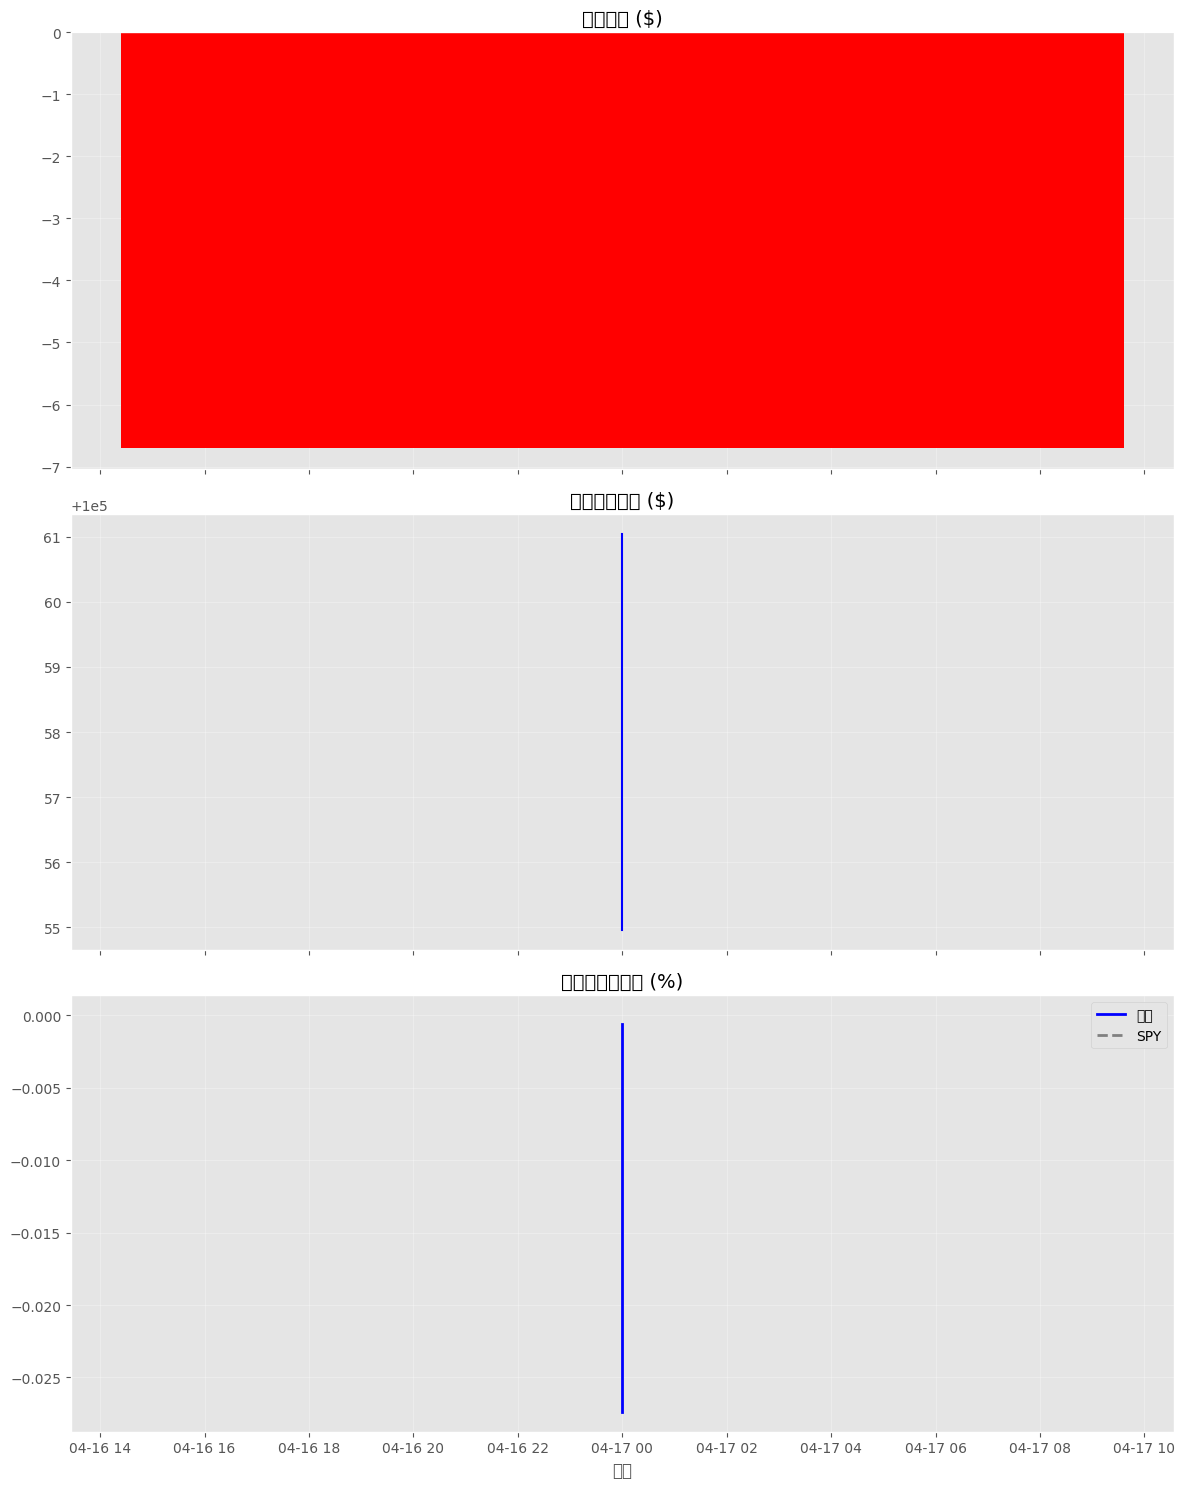

增强版每日报告已生成: data/reports/detailed_report_2025-04-16.html
简单文本报告已生成: data/reports/report_2025-04-16.txt
数据已导出到CSV文件和MySQL数据库
已发送通知: 每日交易报告已生成 - 账户价值: $100054.95, 日收益: -0.01%


'data/reports/detailed_report_2025-04-16.html'

In [46]:
# 或指定日期生成报告
from datetime import datetime, timedelta
yesterday = datetime.now() - timedelta(days=1)
generate_report_if_missing(yesterday)